# SHAP feature selection #
## Code to select feature with combination of LightGBM and SHAP ##

## Parameters cell ##

Parameters are overiddent by papermill when run inside DVC stages



In [1]:
n_folds = 5 # this sets global setting of which how many bootstraps to use
n_hold_out = 1
repeats = 10
importance_type = "split"

life_history = ["lifespan", "mass_kg", "mtGC", "metabolic_rate", "temperature", "gestation_days"]
debug_local = True #to use local version

In [2]:
from pathlib import Path
import sys
import inspect

#lgb_params["importance_type"] = importance_type

local = (Path("..") / "yspecies").resolve()
if debug_local and local.exists():
  sys.path.insert(0, Path("..").as_posix())
  #sys.path.insert(0, local.as_posix())
  print("extending pathes with local yspecies")
  print(sys.path)
  %load_ext autoreload
  %autoreload 2

extending pathes with local yspecies
['..', '/data/sources/yspecies/notebooks', '/data/miniconda3/envs/yspecies/lib/python38.zip', '/data/miniconda3/envs/yspecies/lib/python3.8', '/data/miniconda3/envs/yspecies/lib/python3.8/lib-dynload', '', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/IPython/extensions', '/home/anton/.ipython']


In [3]:
from dataclasses import dataclass, replace
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from typing import *
from yspecies.dataset import *
from yspecies.utils import *
from yspecies.workflow import TupleWith, Repeat, Collect
from yspecies.config import *
from yspecies.preprocess import FeatureSelection, DataExtractor
from yspecies.partition import DataPartitioner, PartitionParameters
from yspecies.models import Metrics
from yspecies.selection import ShapSelector
from yspecies.results import FeatureSummary

In [5]:
import optuna
from optuna import Study, Trial
from optuna import multi_objective
from optuna.multi_objective import trial
from optuna.multi_objective.study import MultiObjectiveStudy
from yspecies.tuning import MultiObjectiveResults

In [6]:
#settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pprint
pp = pprint.PrettyPrinter(indent=4)

#charts settings
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib auto
plt.ioff()
set_matplotlib_formats('svg')

Using matplotlib backend: agg


### Loading data ###
Let's load data from species/genes/expressions selected by select_samples.py notebook

In [7]:
from pathlib import Path
locations: Locations = Locations("./") if Path("./data").exists() else Locations("../")

## Setting up Features to select ##

In [8]:
default_selection = FeatureSelection(
    samples = ["tissue","species"], #samples metadata to include
    species =  [], #species metadata other then Y label to include
    exclude_from_training = ["species"],  #exclude some fields from LightGBM training
    to_predict = "lifespan", #column to predict
    categorical = ["tissue"],
    select_by = "shap",
    importance_type =  importance_type,
    feature_perturbation = "tree_path_dependent"
)
default_selection

FeatureSelection(samples=['tissue', 'species'], species=[], genes=None, to_predict='lifespan', categorical=['tissue'], exclude_from_training=['species'], genes_meta=None, select_by='shap', importance_type='split', feature_perturbation='tree_path_dependent', not_validated_species=[])

In [9]:
loader = DataLoader(locations, default_selection)
selections = loader.load_life_history()
selections["lifespan"][0]

<table border='2'><caption>lifespan<caption><tr><th>expressions</th><th>genes</th><th>species</th><th>samples</th><th>Genes Metadata</th><th>Species Metadata</th></tr><tr><td>(408, 12323)</td><td>(12323, 37)</td><td>38</td><td>408</td><td>(12323, 2)</td><td>(38, 18)</td></tr></table>

### Loading Hyperoptimization studies ###

In [10]:
def load_study(trait: str):
    url = f'sqlite:///' +str((locations.interim.optimization / (trait+".sqlite")).absolute())
    print('loading (if exists) study from '+url)
    storage = optuna.storages.RDBStorage(
        url=url
        #engine_kwargs={'check_same_thread': False}
    )
    return optuna.multi_objective.study.create_study(directions=['maximize','minimize','maximize'], storage = storage, study_name = f"{trait}_r2_huber_kendall", load_if_exists = True)

## Setting up SHAP selection pipeline ##

### Deciding on selection parameters (which fields to include, exclude, predict)  ###

In [11]:
partition_params = PartitionParameters(n_folds, n_hold_out, 2,   42)


In [12]:
def make_pipeline(trait: str, study_name: str = None):
    study_name = trait if study_name is None else study_name
    study = load_study(study_name)
    if len(study.get_pareto_front_trials())>0 :
        metrics, params = MultiObjectiveResults.from_study(study).best_metrics_params_r2()
        params["verbose"] = -1
        if "early_stopping_round" not in params:
            params["early_stopping_round"] = 10
    else:
        params =  lgb_params = {"bagging_fraction": 0.9522534844058304,
                  "boosting_type": "dart",
                  "objective": "regression",
                  "feature_fraction": 0.42236910941558053,
                  "lambda_l1": 0.020847266580277746,
                  "lambda_l2": 2.8448564854773326,
                  "learning_rate": 0.11484015430016059,
                  "max_depth": 3,
                  "max_leaves": 35,
                  "min_data_in_leaf": 9,
                  "num_iterations": 250,
                  "metrics": ["l1", "l2", "huber"]
                 }
    partition_shap_pipe = Pipeline([
    ("partitioner", DataPartitioner()),
    ('prepare_for_selection', TupleWith(params)),
    ("shap_computation", ShapSelector())
    ]
    )
    repeated_cv =  Repeat(partition_shap_pipe, repeats, lambda x,i: (x[0], replace(x[1], seed = i)))
    return Pipeline(
        [
        ('extractor', DataExtractor()),
        ('prepare_for_partitioning', TupleWith(partition_params)), # to extract the data required for ML from the dataset
        ("partition_shap", repeated_cv),
        ("summarize", Collect(fold=lambda results: FeatureSummary(results)))
        ]
        )

In [13]:
pipelines = {trait:make_pipeline(trait) for trait in life_history}
pipelines.keys()

loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/lifespan.sqlite


create_study is experimental (supported from v1.4.0). The interface can change in the future.
NSGAIIMultiObjectiveSampler is experimental (supported from v1.5.0). The interface can change in the future.
RandomMultiObjectiveSampler is experimental (supported from v1.4.0). The interface can change in the future.
[I 2020-09-13 22:06:12,753] Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.
MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/mass_kg.sqlite


[I 2020-09-13 22:06:14,550] Using an existing study with name 'mass_kg_r2_huber_kendall' instead of creating a new one.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/mtGC.sqlite


[I 2020-09-13 22:06:14,856] Using an existing study with name 'mtGC_r2_huber_kendall' instead of creating a new one.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/metabolic_rate.sqlite


[I 2020-09-13 22:06:16,279] Using an existing study with name 'metabolic_rate_r2_huber_kendall' instead of creating a new one.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/temperature.sqlite


[I 2020-09-13 22:06:16,535] Using an existing study with name 'temperature_r2_huber_kendall' instead of creating a new one.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/gestation_days.sqlite


[I 2020-09-13 22:06:16,884] Using an existing study with name 'gestation_days_r2_huber_kendall' instead of creating a new one.


dict_keys(['lifespan', 'mass_kg', 'mtGC', 'metabolic_rate', 'temperature', 'gestation_days'])

# First stage selection (shap ) #

In [14]:
stage_one = {}

### Lifespan ###

In [15]:
def run_stage_one(trait: str):
    result = pipelines[trait].fit_transform(selections[trait])
    stage_one[trait] = result #ugly mutation of stage_one dicionary
    return result

In [16]:
stage_one_lifespan = run_stage_one("lifespan")
stage_one_lifespan.selected

2020-09-13 22:06:18.174 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 0 =====
2020-09-13 22:06:18.175 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-09-13 22:06:18.217 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[136]	valid_0's l1: 9.45903	valid_0's l2: 229.227	valid_0's huber: 8.15653


2020-09-13 22:06:20.098 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[126]	valid_0's l1: 4.44458	valid_0's l2: 75.2891	valid_0's huber: 3.67282


2020-09-13 22:06:21.985 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[108]	valid_0's l1: 3.84279	valid_0's l2: 54.7746	valid_0's huber: 3.13819


2020-09-13 22:06:24.149 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[101]	valid_0's l1: 3.48671	valid_0's l2: 64.2862	valid_0's huber: 2.79989


2020-09-13 22:06:50.901 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.860975682304215, MAE=5.308276431042094, MSE=105.89426332067686, huber=4.438139881104793)
2020-09-13 22:06:50.977 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 1 =====
2020-09-13 22:06:50.979 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-09-13 22:06:51.018 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[121]	valid_0's l1: 3.66333	valid_0's l2: 33.3584	valid_0's huber: 2.94527


2020-09-13 22:06:53.379 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Vombatus_ursinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[141]	valid_0's l1: 5.23023	valid_0's l2: 114.173	valid_0's huber: 4.36805


2020-09-13 22:06:57.117 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[108]	valid_0's l1: 3.38211	valid_0's l2: 39.5527	valid_0's huber: 2.67708


2020-09-13 22:07:00.315 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 6.07959	valid_0's l2: 159.098	valid_0's huber: 5.1493
Did not meet early stopping. Best iteration is:
[248]	valid_0's l1: 6.07952	valid_0's l2: 159.098	valid_0's huber: 5.1494


2020-09-13 22:07:30.548 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8771403494512424, MAE=4.588797523068958, MSE=86.5453145736023, huber=3.7867493140678814)
2020-09-13 22:07:30.622 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 2 =====
2020-09-13 22:07:30.623 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-09-13 22:07:30.663 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argument

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	valid_0's l1: 3.96895	valid_0's l2: 45.8489	valid_0's huber: 3.21764


2020-09-13 22:07:32.443 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Phascolarctos_cinereus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's l1: 4.9685	valid_0's l2: 88.3079	valid_0's huber: 4.11579


2020-09-13 22:07:34.439 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[114]	valid_0's l1: 3.37316	valid_0's l2: 32.1887	valid_0's huber: 2.66844


2020-09-13 22:07:37.785 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[180]	valid_0's l1: 7.61274	valid_0's l2: 123.532	valid_0's huber: 6.46436


2020-09-13 22:08:02.301 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8795354469467518, MAE=4.980837246550187, MSE=72.46932986591808, huber=4.115165144011104)
2020-09-13 22:08:02.374 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 3 =====
2020-09-13 22:08:02.375 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-09-13 22:08:02.407 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[118]	valid_0's l1: 3.72935	valid_0's l2: 36.1783	valid_0's huber: 2.99433


2020-09-13 22:08:04.359 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ursus_americanus', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[204]	valid_0's l1: 7.79581	valid_0's l2: 170.284	valid_0's huber: 6.66516


2020-09-13 22:08:07.006 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[134]	valid_0's l1: 4.23858	valid_0's l2: 66.7263	valid_0's huber: 3.48441


2020-09-13 22:08:09.029 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[125]	valid_0's l1: 2.78445	valid_0's l2: 40.1982	valid_0's huber: 2.14856


2020-09-13 22:08:37.688 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8961796094674944, MAE=4.637046168723452, MSE=78.34662395054613, huber=3.8235683377972958)
2020-09-13 22:08:37.762 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 4 =====
2020-09-13 22:08:37.763 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-09-13 22:08:37.804 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
Found `early_stopping_round` in params. Will use it instead of argument

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[135]	valid_0's l1: 3.77436	valid_0's l2: 45.6228	valid_0's huber: 3.04124


2020-09-13 22:08:39.819 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ursus_americanus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[123]	valid_0's l1: 3.55795	valid_0's l2: 65.0764	valid_0's huber: 2.8754


2020-09-13 22:08:43.338 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[144]	valid_0's l1: 4.63762	valid_0's l2: 50.4576	valid_0's huber: 3.83988


2020-09-13 22:08:45.383 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[183]	valid_0's l1: 6.5324	valid_0's l2: 131.751	valid_0's huber: 5.54932


2020-09-13 22:09:14.790 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8998165426394379, MAE=4.625582525853453, MSE=73.22698623492539, huber=3.8247048240446464)
2020-09-13 22:09:14.863 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 5 =====
2020-09-13 22:09:14.864 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-09-13 22:09:14.901 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
Found `early_stopping_round` in params. Will use it instead of argume

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[132]	valid_0's l1: 2.96422	valid_0's l2: 23.2956	valid_0's huber: 2.32509


2020-09-13 22:09:16.891 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Ovis_aries', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[114]	valid_0's l1: 4.34319	valid_0's l2: 74.457	valid_0's huber: 3.56172


2020-09-13 22:09:20.152 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 4.99543	valid_0's l2: 65.2522	valid_0's huber: 4.15122


2020-09-13 22:09:21.936 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[117]	valid_0's l1: 4.2208	valid_0's l2: 73.1518	valid_0's huber: 3.47395


2020-09-13 22:09:45.637 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.9183501874913238, MAE=4.130907950369613, MSE=59.03914869574248, huber=3.378774833491482)
2020-09-13 22:09:45.712 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 6 =====
2020-09-13 22:09:45.713 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-09-13 22:09:45.746 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it instead 

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[129]	valid_0's l1: 3.87369	valid_0's l2: 43.4285	valid_0's huber: 3.14381


2020-09-13 22:09:47.825 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Suricata_suricatta']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[93]	valid_0's l1: 3.76766	valid_0's l2: 59.4568	valid_0's huber: 3.06761


2020-09-13 22:09:49.678 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[78]	valid_0's l1: 2.46476	valid_0's l2: 22.603	valid_0's huber: 1.8853


2020-09-13 22:09:51.534 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's l1: 4.62613	valid_0's l2: 64.2812	valid_0's huber: 3.81188


2020-09-13 22:10:14.025 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.9339717268738774, MAE=3.6830600381375493, MSE=47.44237198314559, huber=2.97764351915209)
2020-09-13 22:10:14.098 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 7 =====
2020-09-13 22:10:14.099 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-09-13 22:10:14.132 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[96]	valid_0's l1: 3.7583	valid_0's l2: 29.2706	valid_0's huber: 3.02095


2020-09-13 22:10:15.890 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_paniscus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[207]	valid_0's l1: 4.53587	valid_0's l2: 80.8418	valid_0's huber: 3.74688


2020-09-13 22:10:18.364 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[136]	valid_0's l1: 4.50201	valid_0's l2: 52.1369	valid_0's huber: 3.71327


2020-09-13 22:10:20.637 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[125]	valid_0's l1: 4.27706	valid_0's l2: 55.0561	valid_0's huber: 3.49644


2020-09-13 22:10:47.984 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.9261637308111239, MAE=4.268310769408937, MSE=54.32637107002267, huber=3.491153275609779)
2020-09-13 22:10:48.059 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 8 =====
2020-09-13 22:10:48.060 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-09-13 22:10:48.101 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[96]	valid_0's l1: 2.94918	valid_0's l2: 30.057	valid_0's huber: 2.30477


2020-09-13 22:10:49.891 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[95]	valid_0's l1: 4.24574	valid_0's l2: 57.0662	valid_0's huber: 3.48879


2020-09-13 22:10:52.021 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[170]	valid_0's l1: 3.82306	valid_0's l2: 49.9916	valid_0's huber: 3.10081


2020-09-13 22:10:54.223 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[130]	valid_0's l1: 3.82737	valid_0's l2: 60.1879	valid_0's huber: 3.11056


2020-09-13 22:11:20.021 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.9303791884209787, MAE=3.711336866649953, MSE=49.32567431133089, huber=2.99691974515484)
2020-09-13 22:11:20.095 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 9 =====
2020-09-13 22:11:20.096 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-09-13 22:11:20.137 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
Found `early_stopping_round` in params. Will use it instead of arg

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 3.24105	valid_0's l2: 26.8233	valid_0's huber: 2.56484


2020-09-13 22:11:22.183 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[166]	valid_0's l1: 7.05939	valid_0's l2: 152.111	valid_0's huber: 6.00407


2020-09-13 22:11:24.279 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[133]	valid_0's l1: 5.55071	valid_0's l2: 67.4029	valid_0's huber: 4.63997


2020-09-13 22:11:26.184 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[134]	valid_0's l1: 7.00582	valid_0's l2: 154.12	valid_0's huber: 5.94782


2020-09-13 22:11:51.363 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8648537529854701, MAE=5.714241544412328, MSE=100.11435193841979, huber=4.790464258032919)


symbol  repeats  mean_shap  mean_kendall_tau  shap_0  \
ENSG00000010219     DYRK4   10.000      8.375             0.263   8.250   
ENSG00000204498   NFKBIL1   10.000      7.350            -0.141   5.500   
ENSG00000066923     STAG3   10.000      5.525             0.438   5.250   
ENSG00000185880    TRIM69   10.000      5.200             0.140   5.250   
ENSG00000105672      ETV2   10.000      3.550             0.730   2.750   
ENSG00000167515  TRAPPC2L    9.000      6.056            -0.168     nan   
ENSG00000171121    KCNMB3    9.000      4.056             0.667   5.250   
ENSG00000132436    FIGNL1    9.000      3.722             0.544   4.250   
ENSG00000157343    ARMC12    9.000      2.639             0.629   3.000   
ENSG00000170835       CEL    8.000      3.219             0.694   2.500   
ENSG00000188747     NOXA1    8.000      2.656             0.692   1.250   
ENSG00000106554    CHCHD3    7.000      2.929            -0.381     nan   
ENSG00000164362      TERT    7.000      2.893            -0.444   2.250   
ENSG00000129187      DCTD    7.000      1.607             0.624     nan   
ENSG00000144451    SPAG16    6.000      3.625             0.475     nan   
ENSG00000172531    PPP1CA    5.000      2.700            -0.712   2.000   
ENSG00000013288    MAN2B2    5.000      2.650            -0.301     nan   
ENSG00000160948     VPS28    5.000      2.250            -0.329   3.500   
ENSG00000023191      RNH1    4.000      4.000            -0.319     nan   
ENSG00000165555   NOXRED1    4.000      3.938             0.799     nan   
ENSG00000108384    RAD51C    4.000      3.438             0.388     nan   
ENSG00000142002      DPP9    4.000      2.500            -0.703   2.250   
ENSG00000152705  CATSPER3    4.000      2.062             0.684     nan   
ENSG00000132464      ENAM    4.000      2.000             0.491   2.000   
ENSG00000066926      FECH    4.000      1.875            -0.421   1.250   
ENSG00000136436  CALCOCO2    4.000      1.500             0.684     nan   
ENSG00000184983    NDUFA6    3.000      2.750            -0.638     nan   
ENSG00000165501      LRR1    3.000      2.250             0.658     nan   
ENSG00000164879       CA3    3.000      1.083            -0.435     nan   
ENSG00000182612   TSPAN10    2.000      3.875             0.453     nan   
ENSG00000137343     ATAT1    2.000      2.875            -0.403     nan   
ENSG00000142541    RPL13A    2.000      2.625            -0.185   2.750   
ENSG00000213719     CLIC1    2.000      2.500            -0.252     nan   
ENSG00000102265     TIMP1    2.000      2.000             0.589   1.500   
ENSG00000108786   HSD17B1    2.000      1.875             0.651   1.750   
ENSG00000140398     NEIL1    2.000      1.750             0.481     nan   
ENSG00000127952    STYXL1    1.000      4.500             0.595   4.500   
ENSG00000092529     CAPN3    1.000      3.250             0.454     nan   
ENSG00000153157    SYCP2L    1.000      3.250             0.330     nan   
ENSG00000088992      TESC    1.000      3.000             0.475     nan   
ENSG00000278023      RDM1    1.000      3.000            -0.511   3.000   
ENSG00000169045   HNRNPH1    1.000      2.500             0.513     nan   
ENSG00000180336     MEIOC    1.000      2.500             0.107     nan   
ENSG00000166987      MBD6    1.000      2.500            -0.264     nan   
ENSG00000124172   ATP5F1E    1.000      2.500            -0.280     nan   
ENSG00000242715   CCDC169    1.000      2.250             0.568   2.250   
ENSG00000060762      MPC1    1.000      2.250            -0.350   2.250   
ENSG00000203710       CR1    1.000      2.000            -0.468     nan   
ENSG00000166669   ATF7IP2    1.000      1.750             0.625     nan   
ENSG00000162959     MEMO1    1.000      1.750            -0.261     nan   
ENSG00000165689     ENTR1    1.000      1.750            -0.494     nan   
ENSG00000089053    ANAPC5    1.000      1.750            -0.666     nan   
ENSG00000141504      SAT2    1.000      1.50

### saving partitions info  ###

In [ ]:
stage_1_folder = locations.interim.dir / "stage_1"
stage_1_folder.mkdir(exist_ok = True)
stage_one_lifespan.write(stage_1_folder / "partitions", "lifespan_stage_one")
#stage_one_lifespan.partitions.write

### Mass_kg ###

In [17]:
stage_one_mass = run_stage_one("mass_kg")
stage_one_mass.selected

2020-09-13 01:00:41.495 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 0 =====
2020-09-13 01:00:41.496 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-09-13 01:00:41.516 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Monodelphis_domestica', 'Aotus_nancymaae']
Found `early_stopping_round` in params. Will use it instead of argument
Early stopping is not available in dart mode


[250]	valid_0's l1: 13.3421	valid_0's l2: 445.825	valid_0's huber: 11.6282


2020-09-13 01:00:43.764 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Sus_scrofa', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 32.5505	valid_0's l2: 2527.47	valid_0's huber: 28.9213


2020-09-13 01:00:46.139 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Cavia_porcellus']


[250]	valid_0's l1: 6.44605	valid_0's l2: 136.511	valid_0's huber: 5.44781


2020-09-13 01:00:48.302 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Phascolarctos_cinereus']


[250]	valid_0's l1: 8.26742	valid_0's l2: 172.383	valid_0's huber: 7.05276


2020-09-13 01:01:14.708 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8485481700144555, MAE=15.151503721679937, MSE=820.5468217523671, huber=13.262512306432136)
2020-09-13 01:01:14.755 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 1 =====
2020-09-13 01:01:14.756 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-09-13 01:01:14.778 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Mesocricetus_auratus']
Found `early_stopping_round` in params. Will use it instead of argum

[250]	valid_0's l1: 13.1049	valid_0's l2: 649.322	valid_0's huber: 11.46


2020-09-13 01:01:17.343 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Monodelphis_domestica', 'Rattus_norvegicus']


[250]	valid_0's l1: 6.13092	valid_0's l2: 171.041	valid_0's huber: 5.14274


2020-09-13 01:01:21.852 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Sus_scrofa']


[250]	valid_0's l1: 15.2171	valid_0's l2: 569.748	valid_0's huber: 13.3068


2020-09-13 01:01:24.422 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Cavia_porcellus']


[250]	valid_0's l1: 26.7688	valid_0's l2: 1371.43	valid_0's huber: 23.7106


2020-09-13 01:01:49.935 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8114980730930564, MAE=15.30541379125049, MSE=690.3855427300549, huber=13.405051508161213)
2020-09-13 01:01:49.979 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 2 =====
2020-09-13 01:01:49.980 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-09-13 01:01:50.001 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Meriones_unguiculatus']
Found `early_stopping_round` in params. Will use it instead of arg

[250]	valid_0's l1: 4.43469	valid_0's l2: 130.821	valid_0's huber: 3.62287


2020-09-13 01:01:54.710 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Mesocricetus_auratus']


[250]	valid_0's l1: 7.70838	valid_0's l2: 276.304	valid_0's huber: 6.57229


2020-09-13 01:01:57.198 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Phascolarctos_cinereus', 'Cavia_porcellus']


[250]	valid_0's l1: 4.25301	valid_0's l2: 78.4206	valid_0's huber: 3.46288


2020-09-13 01:01:59.625 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Aotus_nancymaae']


[250]	valid_0's l1: 29.2213	valid_0's l2: 1610.48	valid_0's huber: 25.9187


2020-09-13 01:02:24.748 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8576119805557245, MAE=11.404332159528785, MSE=524.0055712291748, huber=9.894175479805348)
2020-09-13 01:02:24.791 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 3 =====
2020-09-13 01:02:24.792 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-09-13 01:02:24.811 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Rattus_norvegicus']
Found `early_stopping_round` in params. Will use it instead of argume

[250]	valid_0's l1: 11.7794	valid_0's l2: 404.186	valid_0's huber: 10.2577


2020-09-13 01:02:26.936 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 27.6127	valid_0's l2: 2568.29	valid_0's huber: 24.5031


2020-09-13 01:02:32.538 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Sus_scrofa', 'Aotus_nancymaae']


[250]	valid_0's l1: 28.0847	valid_0's l2: 2842.88	valid_0's huber: 24.8911


2020-09-13 01:02:35.008 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Mesocricetus_auratus']


[250]	valid_0's l1: 10.909	valid_0's l2: 245.189	valid_0's huber: 9.43465


2020-09-13 01:03:00.555 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.715942725506429, MAE=19.596461582124284, MSE=1515.1366536843038, huber=17.27163264793603)
2020-09-13 01:03:00.599 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 4 =====
2020-09-13 01:03:00.600 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-09-13 01:03:00.619 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it instead of ar

[250]	valid_0's l1: 18.6989	valid_0's l2: 747.411	valid_0's huber: 16.4631


2020-09-13 01:03:02.811 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Aotus_nancymaae']


[250]	valid_0's l1: 20.157	valid_0's l2: 703.449	valid_0's huber: 17.7411


2020-09-13 01:03:05.056 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Homo_sapiens', 'Rattus_norvegicus']


[250]	valid_0's l1: 17.2206	valid_0's l2: 887.106	valid_0's huber: 15.108


2020-09-13 01:03:06.981 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Phascolarctos_cinereus', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 15.5397	valid_0's l2: 458.061	valid_0's huber: 13.596


2020-09-13 01:03:32.260 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8221948225865736, MAE=17.904038888779247, MSE=699.0068526636555, huber=15.7270586724214)
2020-09-13 01:03:32.303 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 5 =====
2020-09-13 01:03:32.304 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-09-13 01:03:32.324 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it instead of 

[250]	valid_0's l1: 18.1693	valid_0's l2: 692.966	valid_0's huber: 15.9763


2020-09-13 01:03:34.722 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Suricata_suricatta']


[250]	valid_0's l1: 14.2218	valid_0's l2: 612.104	valid_0's huber: 12.4202


2020-09-13 01:03:37.054 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Sus_scrofa', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 32.1119	valid_0's l2: 2524.25	valid_0's huber: 28.511


2020-09-13 01:03:39.275 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Otolemur_garnettii']


[250]	valid_0's l1: 7.01175	valid_0's l2: 166.371	valid_0's huber: 5.92653


2020-09-13 01:04:03.691 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8088802262238413, MAE=17.878673494198317, MSE=998.921859590723, huber=15.708482842754393)
2020-09-13 01:04:03.736 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 6 =====
2020-09-13 01:04:03.737 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-09-13 01:04:03.757 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Ictidomys_tridecemlineatus']
Found `early_stopping_round` in params. Will use it instead 

[250]	valid_0's l1: 12.8993	valid_0's l2: 466.238	valid_0's huber: 11.226


2020-09-13 01:04:06.053 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Otolemur_garnettii']


[250]	valid_0's l1: 22.2409	valid_0's l2: 1393.7	valid_0's huber: 19.6887


2020-09-13 01:04:08.159 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Sus_scrofa']


[250]	valid_0's l1: 17.4214	valid_0's l2: 1576.66	valid_0's huber: 15.2861


2020-09-13 01:04:10.269 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Homo_sapiens']


[250]	valid_0's l1: 29.2153	valid_0's l2: 1598.4	valid_0's huber: 25.9009


2020-09-13 01:04:35.878 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.6993167781975327, MAE=20.444239754671482, MSE=1258.7499095040753, huber=18.025435907176202)
2020-09-13 01:04:35.924 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 7 =====
2020-09-13 01:04:35.925 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-09-13 01:04:35.947 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']
Found `early_stopping_round` in params. Will use it instea

[250]	valid_0's l1: 11.3563	valid_0's l2: 474.896	valid_0's huber: 9.82545


2020-09-13 01:04:38.652 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 17.5279	valid_0's l2: 738.663	valid_0's huber: 15.3881


2020-09-13 01:04:41.214 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Monodelphis_domestica']


[250]	valid_0's l1: 17.4364	valid_0's l2: 601.688	valid_0's huber: 15.2897


2020-09-13 01:04:43.484 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Rattus_norvegicus']


[250]	valid_0's l1: 7.08194	valid_0's l2: 155.613	valid_0's huber: 5.9942


2020-09-13 01:05:08.779 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.842247332560213, MAE=13.35062226377475, MSE=492.715139177908, huber=11.62435008786313)
2020-09-13 01:05:08.823 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 8 =====
2020-09-13 01:05:08.824 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-09-13 01:05:08.844 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Otolemur_garnettii']
Found `early_stopping_round` in params. Will use it instead of argum

[250]	valid_0's l1: 23.8751	valid_0's l2: 1322.6	valid_0's huber: 21.173


2020-09-13 01:05:11.100 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Homo_sapiens', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 31.3351	valid_0's l2: 2027.37	valid_0's huber: 27.8118


2020-09-13 01:05:13.253 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Callithrix_jacchus']


[250]	valid_0's l1: 20.138	valid_0's l2: 1108.02	valid_0's huber: 17.8235


2020-09-13 01:05:15.484 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Sus_scrofa']


[250]	valid_0's l1: 12.5898	valid_0's l2: 516.946	valid_0's huber: 10.9398


2020-09-13 01:05:41.835 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.7299498857714628, MAE=21.98452854184054, MSE=1243.7348230338284, huber=19.437009477152277)
2020-09-13 01:05:41.878 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 9 =====
2020-09-13 01:05:41.879 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-09-13 01:05:41.900 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Monodelphis_domestica']
Found `early_stopping_round` in params. Will use it instead o

[250]	valid_0's l1: 14.3026	valid_0's l2: 659.99	valid_0's huber: 12.4787


2020-09-13 01:05:44.350 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Suricata_suricatta']


[250]	valid_0's l1: 17.4403	valid_0's l2: 860.812	valid_0's huber: 15.3553


2020-09-13 01:05:47.076 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Mesocricetus_auratus']


[250]	valid_0's l1: 5.21492	valid_0's l2: 86.4547	valid_0's huber: 4.34632


2020-09-13 01:05:49.286 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Homo_sapiens']


[250]	valid_0's l1: 24.6386	valid_0's l2: 1476.01	valid_0's huber: 21.7903


2020-09-13 01:06:14.572 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8091649123643789, MAE=15.399116505148402, MSE=770.8173285998719, huber=13.492648050140154)


symbol  repeats  mean_shap  mean_kendall_tau  shap_0  \
ENSG00000144214     LYG1    7.000     10.429             0.408   6.250   
ENSG00000124172  ATP5F1E    6.000     20.500            -0.299     nan   
ENSG00000054277     OPN3    5.000     54.900             0.150  34.250   
ENSG00000066923    STAG3    5.000     26.450             0.154  38.750   
ENSG00000126062  TMEM115    5.000     10.750             0.005   7.000   
ENSG00000010219    DYRK4    4.000     21.188             0.212  23.000   
ENSG00000107020   PLGRKT    4.000     13.000             0.015  10.250   
ENSG00000270647    TAF15    4.000     11.750             0.043     nan   
ENSG00000152214     RIT2    4.000      2.875             0.065   2.750   
ENSG00000164304    CAGE1    3.000     15.000            -0.191  19.250   
ENSG00000204498  NFKBIL1    3.000      7.083            -0.193   8.500   
ENSG00000102265    TIMP1    3.000      3.417             0.031   2.250   
ENSG00000117151     CTBS    2.000     21.500            -0.268     nan   
ENSG00000108384   RAD51C    2.000      8.750             0.173   8.750   
ENSG00000101104  PABPC1L    2.000      1.875             0.308     nan   
ENSG00000109061     MYH1    1.000     33.000             0.070     nan   
ENSG00000127952   STYXL1    1.000     15.250             0.304     nan   
ENSG00000138430     OLA1    1.000     15.250             0.172     nan   
ENSG00000179532    DNHD1    1.000     14.500             0.299     nan   
ENSG00000213719    CLIC1    1.000     12.500            -0.091     nan   
ENSG00000160796   NBEAL2    1.000     12.250             0.071     nan   
ENSG00000175806     MSRA    1.000     10.750            -0.073     nan   
ENSG00000162438     CTRC    1.000     10.500             0.085     nan   
ENSG00000155849    ELMO1    1.000      8.250             0.190     nan   
ENSG00000092529    CAPN3    1.000      4.500             0.166     nan   
ENSG00000105397     TYK2    1.000      4.250             0.282     nan   
ENSG00000101842    VSIG1    1.000      4.000             0.460     nan   
ENSG00000164010    ERMAP    1.000      3.750             0.387     nan   
ENSG00000162949   CAPN13    1.000      3.500            -0.280   3.500   
ENSG00000136247   ZDHHC4    1.000      3.250            -0.022     nan   
ENSG00000182095   TNRC18    1.000      2.750             0.290     nan   
ENSG00000105379     ETFB    1.000      2.000             0.185   2.000   
ENSG00000144488    ESPNL    1.000      2.000             0.142   2.000   
ENSG00000231925    TAPBP    1.000      2.000             0.026     nan   
ENSG00000169857     AVEN    1.000      1.750            -0.157     nan   
ENSG00000171960     PPIH    1.000      1.750            -0.299     nan   
ENSG00000133256    PDE6B    1.000      1.500             0.281     nan   
ENSG00000118363    SPCS2    1.000      1.000             0.343   1.000   
ENSG00000182853     VMO1    1.000      1.000             0.313     nan   
ENSG00000103005     USB1    1.000      1.000            -0.500     nan   

                 kendall_tau_0  shap_1  kendall_tau_1  shap_2  kendall_tau_2  \
ENSG00000144214          0.413  17.750          0.406  11.000          0.319   
ENSG00000124172            nan     nan            nan   2.250         -0.276   
ENSG00000054277          0.164     nan            nan  66.750          0.267   
ENSG00000066923          0.222     nan            nan  11.500          0.147   
ENSG00000126062          0.014   8.250         -0.090     nan            nan   
ENSG00000010219          0.245     nan            nan     nan            nan   
ENSG00000107020         -0.035  12.500          0.053     nan            nan   
ENSG00000270647            nan  13.250          0.023  11.250          0.005   
ENSG00000152214          0.089   2.250          0.080     nan            nan   
ENSG00000164304         -0.215   3.250         -0.214     nan            nan   
ENSG00000204498         -0.236     nan            nan     nan            nan   
ENSG00000102265        

### MtGC ###

In [18]:
stage_one_mtGC = run_stage_one("mtGC")
stage_one_mtGC.selected

2020-09-13 01:06:14.762 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 0 =====
2020-09-13 01:06:14.763 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-09-13 01:06:14.791 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Sus_scrofa']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[104]	valid_0's l1: 0.478724	valid_0's l2: 0.473509	valid_0's huber: 0.201354


2020-09-13 01:06:17.862 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 1.02058	valid_0's l2: 1.47366	valid_0's huber: 0.588529


2020-09-13 01:06:19.559 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Equus_caballus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[121]	valid_0's l1: 0.591852	valid_0's l2: 1.02221	valid_0's huber: 0.327309


2020-09-13 01:06:22.747 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 0.651227	valid_0's l2: 0.700004	valid_0's huber: 0.316245


2020-09-13 01:06:41.455 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8735531748595802, MAE=0.6855961213531605, MSE=0.917346100381866, huber=0.3586589301104447)
2020-09-13 01:06:41.509 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 1 =====
2020-09-13 01:06:41.510 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-09-13 01:06:41.537 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Felis_catus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[84]	valid_0's l1: 0.423146	valid_0's l2: 0.401722	valid_0's huber: 0.172858


2020-09-13 01:06:45.660 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	valid_0's l1: 0.527124	valid_0's l2: 0.754368	valid_0's huber: 0.282179


2020-09-13 01:06:48.195 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Sus_scrofa']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[50]	valid_0's l1: 0.481812	valid_0's l2: 0.689243	valid_0's huber: 0.237233


2020-09-13 01:06:50.355 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Bos_taurus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 0.547681	valid_0's l2: 0.752035	valid_0's huber: 0.268196
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 0.547681	valid_0's l2: 0.752035	valid_0's huber: 0.268196


2020-09-13 01:07:14.849 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.911623843935351, MAE=0.49494095436268293, MSE=0.649341972808765, huber=0.23956065062180582)
2020-09-13 01:07:14.907 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 2 =====
2020-09-13 01:07:14.909 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-09-13 01:07:14.933 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Sus_scrofa']
Found `early_stopping_round` in params. Will use it instead of argumen

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[94]	valid_0's l1: 0.573004	valid_0's l2: 0.679099	valid_0's huber: 0.272191


2020-09-13 01:07:17.126 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 0.551605	valid_0's l2: 0.596688	valid_0's huber: 0.24864
Did not meet early stopping. Best iteration is:
[248]	valid_0's l1: 0.551593	valid_0's l2: 0.596669	valid_0's huber: 0.248631


2020-09-13 01:07:20.322 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Felis_catus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 0.553113	valid_0's l2: 0.761627	valid_0's huber: 0.271429
Did not meet early stopping. Best iteration is:
[249]	valid_0's l1: 0.553112	valid_0's l2: 0.761612	valid_0's huber: 0.271427


2020-09-13 01:07:23.518 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Equus_caballus', 'Pan_paniscus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[179]	valid_0's l1: 0.787205	valid_0's l2: 1.68224	valid_0's huber: 0.491742


2020-09-13 01:07:52.728 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.9063659098056718, MAE=0.6162285295802585, MSE=0.9299058959058761, huber=0.3210217969846083)
2020-09-13 01:07:52.788 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 3 =====
2020-09-13 01:07:52.789 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-09-13 01:07:52.816 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Ursus_americanus', 'Phascolarctos_cinereus']
Found `early_stopping_round` in params. Will use it instead of 

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[149]	valid_0's l1: 0.653539	valid_0's l2: 1.0689	valid_0's huber: 0.360877


2020-09-13 01:07:56.023 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Macaca_mulatta']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[137]	valid_0's l1: 0.929314	valid_0's l2: 3.2299	valid_0's huber: 0.636209


2020-09-13 01:07:59.198 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[94]	valid_0's l1: 0.792679	valid_0's l2: 1.44395	valid_0's huber: 0.476699


2020-09-13 01:08:01.815 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 0.871501	valid_0's l2: 1.73121	valid_0's huber: 0.528215


2020-09-13 01:08:16.540 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.7430875834085277, MAE=0.8117582862825798, MSE=1.8684902645872836, huber=0.4861390227596827)
2020-09-13 01:08:16.595 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 4 =====
2020-09-13 01:08:16.596 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-09-13 01:08:16.624 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Vombatus_ursinus']
Found `early_stopping_round` in params. Will use it instead of ar

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[62]	valid_0's l1: 1.10123	valid_0's l2: 2.39726	valid_0's huber: 0.718852


2020-09-13 01:08:18.846 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Mus_musculus', 'Macaca_nemestrina']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's l1: 0.810496	valid_0's l2: 1.1462	valid_0's huber: 0.453993


2020-09-13 01:08:21.357 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[116]	valid_0's l1: 0.797725	valid_0's l2: 1.56245	valid_0's huber: 0.474352


2020-09-13 01:08:24.307 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Capra_hircus', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[128]	valid_0's l1: 0.6453	valid_0's l2: 1.19209	valid_0's huber: 0.361946


2020-09-13 01:08:43.608 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.7891555711970988, MAE=0.8386866645252151, MSE=1.574500612610871, huber=0.5023390482710913)
2020-09-13 01:08:43.661 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 5 =====
2020-09-13 01:08:43.662 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-09-13 01:08:43.689 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Vombatus_ursinus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 0.619234	valid_0's l2: 0.948339	valid_0's huber: 0.348644
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 0.619234	valid_0's l2: 0.948339	valid_0's huber: 0.348644


2020-09-13 01:08:47.642 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Sus_scrofa', 'Rhinolophus_ferrumequinum']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[93]	valid_0's l1: 0.489302	valid_0's l2: 0.899299	valid_0's huber: 0.254094


2020-09-13 01:08:50.236 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Bos_taurus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[163]	valid_0's l1: 0.595418	valid_0's l2: 0.862198	valid_0's huber: 0.328847


2020-09-13 01:08:53.696 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[97]	valid_0's l1: 0.649124	valid_0's l2: 0.972947	valid_0's huber: 0.358125


2020-09-13 01:09:20.341 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8737860688898453, MAE=0.5882695554621669, MSE=0.9206958062050792, huber=0.322497552671098)
2020-09-13 01:09:20.394 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 6 =====
2020-09-13 01:09:20.395 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-09-13 01:09:20.422 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Ursus_americanus', 'Tupaia_belangeri']
Found `early_stopping_round` in params. Will use it instead of argumen

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[91]	valid_0's l1: 0.605769	valid_0's l2: 1.0416	valid_0's huber: 0.337539


2020-09-13 01:09:22.954 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 0.478837	valid_0's l2: 0.798489	valid_0's huber: 0.247114


2020-09-13 01:09:25.590 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[181]	valid_0's l1: 0.345218	valid_0's l2: 0.259429	valid_0's huber: 0.122635


2020-09-13 01:09:28.798 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Ictidomys_tridecemlineatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[54]	valid_0's l1: 0.816399	valid_0's l2: 2.81008	valid_0's huber: 0.528305


2020-09-13 01:09:49.436 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8365383354409, MAE=0.5615557044883318, MSE=1.227399393024815, huber=0.30814467466556006)
2020-09-13 01:09:49.487 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 7 =====
2020-09-13 01:09:49.489 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-09-13 01:09:49.515 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Sus_scrofa', 'Macaca_fascicularis']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[129]	valid_0's l1: 0.458733	valid_0's l2: 0.436492	valid_0's huber: 0.194139


2020-09-13 01:09:52.703 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 1.10289	valid_0's l2: 2.63805	valid_0's huber: 0.711355


2020-09-13 01:09:54.677 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[183]	valid_0's l1: 0.668857	valid_0's l2: 1.17441	valid_0's huber: 0.365626


2020-09-13 01:10:01.307 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Mus_musculus', 'Equus_caballus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[102]	valid_0's l1: 0.908522	valid_0's l2: 1.48671	valid_0's huber: 0.552053


2020-09-13 01:10:20.198 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8030569037077978, MAE=0.784749891330608, MSE=1.4339170675155786, huber=0.4518184795085066)
2020-09-13 01:10:20.253 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 8 =====
2020-09-13 01:10:20.254 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-09-13 01:10:20.282 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Ailuropoda_melanoleuca']
Found `early_stopping_round` in params. Will use it instead of arg

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[152]	valid_0's l1: 0.562463	valid_0's l2: 0.755986	valid_0's huber: 0.282626


2020-09-13 01:10:23.675 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 0.59224	valid_0's l2: 0.744214	valid_0's huber: 0.296388


2020-09-13 01:10:25.907 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Mesocricetus_auratus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	valid_0's l1: 1.02804	valid_0's l2: 2.82989	valid_0's huber: 0.710877


2020-09-13 01:10:28.354 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[146]	valid_0's l1: 0.567974	valid_0's l2: 0.672868	valid_0's huber: 0.280583


2020-09-13 01:10:49.598 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8456615414896915, MAE=0.6876783922265179, MSE=1.2507388191040372, huber=0.392833235658935)
2020-09-13 01:10:49.648 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 9 =====
2020-09-13 01:10:49.650 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-09-13 01:10:49.675 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Meriones_unguiculatus']
Found `early_stopping_round` in params. Will use it instead of a

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's l1: 1.00392	valid_0's l2: 1.74339	valid_0's huber: 0.593614


2020-09-13 01:10:51.474 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Phascolarctos_cinereus', 'Pan_troglodytes']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[130]	valid_0's l1: 0.829213	valid_0's l2: 1.42613	valid_0's huber: 0.47907


2020-09-13 01:10:54.677 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Ailuropoda_melanoleuca', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[79]	valid_0's l1: 0.587505	valid_0's l2: 0.909156	valid_0's huber: 0.320914


2020-09-13 01:10:57.441 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Cavia_porcellus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[41]	valid_0's l1: 0.973238	valid_0's l2: 1.77864	valid_0's huber: 0.577021


2020-09-13 01:11:10.142 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.771141896946768, MAE=0.8484695237196214, MSE=1.4643304061387927, huber=0.4901653261780517)


symbol  repeats  mean_shap  mean_kendall_tau  shap_0  \
ENSG00000171121    KCNMB3   10.000     10.025             0.641  10.250   
ENSG00000122034     GTF3A   10.000      9.650             0.632  10.750   
ENSG00000144451    SPAG16   10.000      7.200             0.390   6.250   
ENSG00000196419     XRCC6    8.000     11.375             0.637   8.750   
ENSG00000167515  TRAPPC2L    8.000      4.031            -0.514   4.250   
ENSG00000163528    CHCHD4    6.000      5.333             0.402     nan   
ENSG00000167272      POP5    6.000      5.292            -0.381     nan   
ENSG00000122952     ZWINT    6.000      3.292            -0.663   3.000   
ENSG00000069869     NEDD4    6.000      2.542             0.010   4.250   
ENSG00000168300    PCMTD1    5.000      7.900             0.149   6.250   
ENSG00000006282   SPATA20    5.000      6.750             0.692     nan   
ENSG00000154328     NEIL2    5.000      6.500             0.652     nan   
ENSG00000188747     NOXA1    5.000      6.250             0.623   6.750   
ENSG00000178982     EIF3K    5.000      5.750             0.253   9.500   
ENSG00000176105      YES1    5.000      4.750             0.204   4.250   
ENSG00000171747    LGALS4    5.000      4.600            -0.664     nan   
ENSG00000164304     CAGE1    5.000      4.500            -0.695     nan   
ENSG00000156384      SFR1    5.000      4.150            -0.670   5.250   
ENSG00000055950    MRPL43    5.000      3.450             0.574   3.250   
ENSG00000129187      DCTD    5.000      2.750             0.678   3.000   
ENSG00000048140   TSPAN17    5.000      2.700            -0.414     nan   
ENSG00000170835       CEL    5.000      2.400             0.638     nan   
ENSG00000211454     AKR7L    4.000      4.688            -0.375     nan   
ENSG00000101190     TCFL5    4.000      4.250             0.554     nan   
ENSG00000177143     CETN1    4.000      3.562            -0.462     nan   
ENSG00000138678     GPAT3    4.000      3.125             0.070   3.750   
ENSG00000154582      ELOC    4.000      2.812            -0.482     nan   
ENSG00000167863    ATP5PD    4.000      2.750            -0.614   2.250   
ENSG00000023191      RNH1    4.000      2.188            -0.520     nan   
ENSG00000164362      TERT    3.000      5.917            -0.447   7.000   
ENSG00000092529     CAPN3    3.000      3.917             0.458   4.000   
ENSG00000101928    MOSPD1    3.000      3.750            -0.336     nan   
ENSG00000151006    PRSS53    3.000      3.000             0.622   1.250   
ENSG00000065548    ZC3H15    3.000      2.500             0.275     nan   
ENSG00000100908      EMC9    3.000      2.333            -0.606     nan   
ENSG00000278845    MRPL45    3.000      2.333            -0.645   2.750   
ENSG00000102699     PARP4    3.000      2.250             0.580     nan   
ENSG00000160447      PKN3    3.000      1.917             0.561     nan   
ENSG00000181704     YIPF6    3.000      1.750             0.300   1.500   
ENSG00000135452   TSPAN31    3.000      1.667             0.607   1.250   
ENSG00000134308     YWHAQ    3.000      1.667             0.452   1.750   
ENSG00000269058     CALR3    2.000      3.750            -0.474     nan   
ENSG00000168393     DTYMK    2.000      3.750            -0.619     nan   
ENSG00000157778     PSMG3    2.000      3.375             0.621     nan   
ENSG00000204954  C12orf73    2.000      3.125            -0.668     nan   
ENSG00000105672      ETV2    2.000      3.000             0.633   2.000   
ENSG00000242866      STRC    2.000      2.500             0.516     nan   
ENSG00000197629     MPEG1    2.000      2.375            -0.528     nan   
ENSG00000163584   RPL22L1    2.000      2.375            -0.626   1.750   
ENSG00000120594    PLXDC2    2.000      2.250             0.380     nan   
ENSG00000164010     ERMAP    2.000      2.000             0.479     nan   
ENSG00000182774     RPS17    2.000      2.000            -0.393     nan   
ENSG00000120992    LYPLA1    2.000      2.00

### Metabolism ###

In [19]:
stage_one_metabolic_rate = run_stage_one("metabolic_rate")
stage_one_metabolic_rate.selected

2020-09-13 01:11:10.322 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 0 =====
2020-09-13 01:11:10.323 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-09-13 01:11:10.341 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Monodelphis_domestica', 'Cavia_porcellus']
Found `early_stopping_round` in params. Will use it instead of argument
Early stopping is not available in dart mode


[250]	valid_0's l1: 12.9298	valid_0's l2: 299.517	valid_0's huber: 11.2671


2020-09-13 01:11:14.353 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Sus_scrofa', 'Phascolarctos_cinereus']


[250]	valid_0's l1: 23.1846	valid_0's l2: 1147.18	valid_0's huber: 20.484


2020-09-13 01:11:20.434 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Rattus_norvegicus']


[250]	valid_0's l1: 6.92015	valid_0's l2: 116.413	valid_0's huber: 5.84312


2020-09-13 01:11:24.815 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 25.9153	valid_0's l2: 1399.09	valid_0's huber: 23.0034


2020-09-13 01:11:53.567 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.7945335871650265, MAE=17.23747331436197, MSE=740.5506064031485, huber=15.149422934940768)
2020-09-13 01:11:53.610 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 1 =====
2020-09-13 01:11:53.611 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-09-13 01:11:53.629 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Meriones_unguiculatus']
Found `early_stopping_round` in params. Will use it instead of argume

[250]	valid_0's l1: 16.6079	valid_0's l2: 511.446	valid_0's huber: 14.5603


2020-09-13 01:11:58.075 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Monodelphis_domestica', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 10.3028	valid_0's l2: 225.13	valid_0's huber: 8.90378


2020-09-13 01:12:02.200 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Sus_scrofa']


[250]	valid_0's l1: 19.7717	valid_0's l2: 655.623	valid_0's huber: 17.4033


2020-09-13 01:12:06.999 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Rattus_norvegicus']


[250]	valid_0's l1: 17.3135	valid_0's l2: 1105.72	valid_0's huber: 15.2339


2020-09-13 01:12:33.870 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.7880732362857129, MAE=15.99896526417836, MSE=624.4788064987699, huber=14.025339657643276)
2020-09-13 01:12:33.915 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 2 =====
2020-09-13 01:12:33.916 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-09-13 01:12:33.936 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Mus_musculus']
Found `early_stopping_round` in params. Will use it instead of argu

[250]	valid_0's l1: 7.49281	valid_0's l2: 312.702	valid_0's huber: 6.3774


2020-09-13 01:12:38.618 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


[250]	valid_0's l1: 12.9119	valid_0's l2: 441.071	valid_0's huber: 11.2439


2020-09-13 01:12:43.496 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Rattus_norvegicus']


[250]	valid_0's l1: 5.65935	valid_0's l2: 117.544	valid_0's huber: 4.72731


2020-09-13 01:12:46.791 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Cavia_porcellus']


[250]	valid_0's l1: 30.8805	valid_0's l2: 1845.47	valid_0's huber: 27.4037


2020-09-13 01:13:14.460 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.7741022481439785, MAE=14.236155481783232, MSE=679.1976032604521, huber=12.438071101945848)
2020-09-13 01:13:14.505 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 3 =====
2020-09-13 01:13:14.506 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-09-13 01:13:14.523 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Ictidomys_tridecemlineatus']
Found `early_stopping_round` in params. Will use it instea

[250]	valid_0's l1: 12.8417	valid_0's l2: 428.119	valid_0's huber: 11.1704


2020-09-13 01:13:18.862 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Phascolarctos_cinereus']


[250]	valid_0's l1: 21.7377	valid_0's l2: 977.685	valid_0's huber: 19.1758


2020-09-13 01:13:23.112 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Sus_scrofa', 'Cavia_porcellus']


[250]	valid_0's l1: 14.2787	valid_0's l2: 481.611	valid_0's huber: 12.4572


2020-09-13 01:13:26.608 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Mus_musculus', 'Meriones_unguiculatus']


[250]	valid_0's l1: 17.6829	valid_0's l2: 663.79	valid_0's huber: 15.5345


2020-09-13 01:13:54.622 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8036655307879486, MAE=16.635218945775875, MSE=637.8010064167084, huber=14.584460994319702)
2020-09-13 01:13:54.667 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 4 =====
2020-09-13 01:13:54.669 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-09-13 01:13:54.687 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Rattus_norvegicus']
Found `early_stopping_round` in params. Will use it instead of argu

[250]	valid_0's l1: 5.67151	valid_0's l2: 123.65	valid_0's huber: 4.72879


2020-09-13 01:13:58.292 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Homo_sapiens']


[250]	valid_0's l1: 32.098	valid_0's l2: 2232.7	valid_0's huber: 28.4907


2020-09-13 01:14:03.005 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 15.5909	valid_0's l2: 573.727	valid_0's huber: 13.6946


2020-09-13 01:14:07.397 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Monodelphis_domestica']


[250]	valid_0's l1: 17.9015	valid_0's l2: 498.779	valid_0's huber: 15.7154


2020-09-13 01:14:34.678 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.7593791019663757, MAE=17.81549233100962, MSE=857.2139181507185, huber=15.657344404631983)
2020-09-13 01:14:34.721 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 5 =====
2020-09-13 01:14:34.722 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-09-13 01:14:34.740 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Phascolarctos_cinereus', 'Mus_musculus']
Found `early_stopping_round` in params. Will use it instead of argument

[250]	valid_0's l1: 11.0117	valid_0's l2: 417.251	valid_0's huber: 9.52131


2020-09-13 01:14:38.612 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Sus_scrofa']


[250]	valid_0's l1: 33.0368	valid_0's l2: 2128.17	valid_0's huber: 29.329


2020-09-13 01:14:43.760 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 13.9407	valid_0's l2: 496.123	valid_0's huber: 12.1749


2020-09-13 01:14:48.297 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Rattus_norvegicus']


[250]	valid_0's l1: 5.91478	valid_0's l2: 112.782	valid_0's huber: 4.97024


2020-09-13 01:15:18.870 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8353991493546684, MAE=15.975994511791308, MSE=788.5805062829171, huber=13.998839872228348)
2020-09-13 01:15:18.910 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 6 =====
2020-09-13 01:15:18.911 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-09-13 01:15:18.930 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Callithrix_jacchus']
Found `early_stopping_round` in params. Will use it instead of arg

[250]	valid_0's l1: 9.82229	valid_0's l2: 356.646	valid_0's huber: 8.4663


2020-09-13 01:15:23.076 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Phascolarctos_cinereus', 'Otolemur_garnettii']


[250]	valid_0's l1: 15.4328	valid_0's l2: 542.44	valid_0's huber: 13.5449


2020-09-13 01:15:27.105 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Mus_musculus', 'Sus_scrofa']


[250]	valid_0's l1: 4.2894	valid_0's l2: 65.7323	valid_0's huber: 3.48987


2020-09-13 01:15:30.741 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Meriones_unguiculatus']


[250]	valid_0's l1: 31.3193	valid_0's l2: 2011.44	valid_0's huber: 27.7839


2020-09-13 01:15:57.932 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.7718983739980873, MAE=15.215949451054612, MSE=744.0641825567918, huber=13.321244532426777)
2020-09-13 01:15:57.974 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 7 =====
2020-09-13 01:15:57.975 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-09-13 01:15:57.995 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Callithrix_jacchus']
Found `early_stopping_round` in params. Will use it instead of argum

[250]	valid_0's l1: 20.0925	valid_0's l2: 1051.53	valid_0's huber: 17.7205


2020-09-13 01:16:02.875 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Phascolarctos_cinereus']


[250]	valid_0's l1: 15.6413	valid_0's l2: 554.251	valid_0's huber: 13.7302


2020-09-13 01:16:07.678 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


[250]	valid_0's l1: 10.2247	valid_0's l2: 360.571	valid_0's huber: 8.80431


2020-09-13 01:16:10.600 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Mesocricetus_auratus']


[250]	valid_0's l1: 10.4262	valid_0's l2: 231.591	valid_0's huber: 8.99999


2020-09-13 01:16:38.639 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8202767956500678, MAE=14.096156404683278, MSE=549.4868881193744, huber=12.313747330790829)
2020-09-13 01:16:38.682 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 8 =====
2020-09-13 01:16:38.683 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-09-13 01:16:38.701 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Phascolarctos_cinereus', 'Otolemur_garnettii']
Found `early_stopping_round` in params. Will use it instead of a

[250]	valid_0's l1: 18.7097	valid_0's l2: 961.245	valid_0's huber: 16.4745


2020-09-13 01:16:42.137 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Homo_sapiens', 'Callithrix_jacchus']


[250]	valid_0's l1: 34.9677	valid_0's l2: 2175.13	valid_0's huber: 31.081


2020-09-13 01:16:45.676 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Mesocricetus_auratus']


[250]	valid_0's l1: 11.9774	valid_0's l2: 362.313	valid_0's huber: 10.4149


2020-09-13 01:16:48.391 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Sus_scrofa']


[250]	valid_0's l1: 19.0748	valid_0's l2: 931.874	valid_0's huber: 16.8164


2020-09-13 01:17:14.385 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.724799994134867, MAE=21.182387259475497, MSE=1107.6412044337683, huber=18.696680579503262)
2020-09-13 01:17:14.428 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 9 =====
2020-09-13 01:17:14.429 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-09-13 01:17:14.448 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Monodelphis_domestica', 'Cavia_porcellus']
Found `early_stopping_round` in params. Will use it instead of argum

[250]	valid_0's l1: 15.3069	valid_0's l2: 615.13	valid_0's huber: 13.4155


2020-09-13 01:17:18.219 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 13.1859	valid_0's l2: 479.649	valid_0's huber: 11.5268


2020-09-13 01:17:23.224 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Mus_musculus']


[250]	valid_0's l1: 5.03709	valid_0's l2: 48.1837	valid_0's huber: 4.14782


2020-09-13 01:17:27.549 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Otolemur_garnettii']


[250]	valid_0's l1: 31.8386	valid_0's l2: 2012.26	valid_0's huber: 28.2706


2020-09-13 01:17:56.065 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.7532232291971745, MAE=16.342121156276164, MSE=788.80540000597, huber=14.340174998612655)


symbol  repeats  mean_shap  mean_kendall_tau  shap_0  \
ENSG00000124172   ATP5F1E    6.000     27.708            -0.252  24.250   
ENSG00000270647     TAF15    6.000     23.583            -0.107     nan   
ENSG00000107020    PLGRKT    5.000     29.850             0.011  21.250   
ENSG00000054277      OPN3    4.000     39.438             0.092   2.000   
ENSG00000171747    LGALS4    4.000      6.625            -0.639  10.000   
ENSG00000175806      MSRA    3.000     17.167            -0.036  26.000   
ENSG00000127952    STYXL1    3.000      9.750             0.291     nan   
ENSG00000134825   TMEM258    3.000      5.500             0.581   9.750   
ENSG00000156467     UQCRB    3.000      3.000            -0.419   3.250   
ENSG00000198931      APRT    3.000      2.583             0.480   1.750   
ENSG00000164304     CAGE1    2.000     32.125            -0.225  29.500   
ENSG00000117151      CTBS    2.000     23.625            -0.090  21.750   
ENSG00000102901     CENPT    2.000     21.875             0.322     nan   
ENSG00000103150     MLYCD    2.000      8.875            -0.228     nan   
ENSG00000189043    NDUFA4    2.000      5.000            -0.318     nan   
ENSG00000164182   NDUFAF2    2.000      4.000            -0.588     nan   
ENSG00000101546      RBFA    2.000      3.875             0.423     nan   
ENSG00000183625      CCR3    2.000      3.500             0.282     nan   
ENSG00000103005      USB1    2.000      3.250             0.435     nan   
ENSG00000160446   ZDHHC12    2.000      3.250             0.140     nan   
ENSG00000198663   C6orf89    2.000      2.125            -0.463     nan   
ENSG00000182853      VMO1    2.000      1.750             0.349     nan   
ENSG00000077713  SLC25A43    2.000      1.625             0.321     nan   
ENSG00000108556     CHRNE    2.000      1.500             0.605   1.250   
ENSG00000105617     LENG1    1.000     34.000             0.023     nan   
ENSG00000278023      RDM1    1.000     19.750            -0.352     nan   
ENSG00000213719     CLIC1    1.000     18.250            -0.142     nan   
ENSG00000144214      LYG1    1.000     15.000             0.450     nan   
ENSG00000278845    MRPL45    1.000     14.000            -0.217     nan   
ENSG00000136247    ZDHHC4    1.000     13.500            -0.047     nan   
ENSG00000169857      AVEN    1.000     11.500            -0.170     nan   
ENSG00000065457     ADAT1    1.000     11.250             0.200     nan   
ENSG00000137411     VARS2    1.000     11.250             0.009     nan   
ENSG00000162814   SPATA17    1.000     11.000            -0.323     nan   
ENSG00000161055   SCGB3A1    1.000      9.000             0.147     nan   
ENSG00000170542  SERPINB9    1.000      6.500             0.688     nan   
ENSG00000204498   NFKBIL1    1.000      5.500            -0.344     nan   
ENSG00000197622  CDC42SE1    1.000      5.250            -0.016     nan   
ENSG00000160796    NBEAL2    1.000      5.000            -0.104     nan   
ENSG00000108384    RAD51C    1.000      4.750             0.391     nan   
ENSG00000174695  TMEM167A    1.000      4.250             0.647   4.250   
ENSG00000137720   C11orf1    1.000      4.250             0.295     nan   
ENSG00000153006  SREK1IP1    1.000      4.250            -0.588     nan   
ENSG00000131943  C19orf12    1.000      4.000             0.641     nan   
ENSG00000169989     TIGD4    1.000      4.000            -0.115     nan   
ENSG00000100220      RTCB    1.000      4.000            -0.128     nan   
ENSG00000128573     FOXP2    1.000      4.000            -0.264   4.000   
ENSG00000010219     DYRK4    1.000      3.750             0.487     nan   
ENSG00000154328     NEIL2    1.000      3.500             0.251   3.500   
ENSG00000109917      ZPR1    1.000      3.500             0.031     nan   
ENSG00000049245     VAMP3    1.000      3.500             0.011     nan   
ENSG00000164404      GDF9    1.000      3.250             0.491     nan   
ENSG00000186010   NDUFA13    1.000      3.00

### Temperature ###

In [20]:
stage_one_temperature = run_stage_one("temperature")
stage_one_temperature.selected

2020-09-13 01:17:56.260 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 0 =====
2020-09-13 01:17:56.261 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-09-13 01:17:56.287 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[95]	valid_0's l1: 0.37369	valid_0's l2: 0.281856	valid_0's huber: 0.127591


2020-09-13 01:17:57.967 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Cavia_porcellus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 1.14129	valid_0's l2: 2.16311	valid_0's huber: 0.716447


2020-09-13 01:17:59.455 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Mesocricetus_auratus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[41]	valid_0's l1: 0.725062	valid_0's l2: 0.944916	valid_0's huber: 0.368779


2020-09-13 01:18:00.927 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Ictidomys_tridecemlineatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[143]	valid_0's l1: 0.436969	valid_0's l2: 0.412512	valid_0's huber: 0.169024


2020-09-13 01:18:13.472 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.7656173069976194, MAE=0.6692532253355442, MSE=0.9506000254337995, huber=0.34466754122458143)
2020-09-13 01:18:13.519 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 1 =====
2020-09-13 01:18:13.520 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-09-13 01:18:13.545 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Equus_caballus', 'Macaca_mulatta']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[110]	valid_0's l1: 0.336947	valid_0's l2: 0.430651	valid_0's huber: 0.150981


2020-09-13 01:18:15.513 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Felis_catus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 0.649716	valid_0's l2: 1.02427	valid_0's huber: 0.347902


2020-09-13 01:18:16.676 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Suricata_suricatta']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 0.385982	valid_0's l2: 0.24094	valid_0's huber: 0.118862
Did not meet early stopping. Best iteration is:
[249]	valid_0's l1: 0.385979	valid_0's l2: 0.240937	valid_0's huber: 0.118861


2020-09-13 01:18:19.321 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Callithrix_jacchus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid_0's l1: 1.03776	valid_0's l2: 1.61038	valid_0's huber: 0.628181


2020-09-13 01:18:32.859 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.761819347533132, MAE=0.602600614202098, MSE=0.8265588499578714, huber=0.30078530839743595)
2020-09-13 01:18:32.908 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 2 =====
2020-09-13 01:18:32.909 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-09-13 01:18:32.934 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[81]	valid_0's l1: 0.328861	valid_0's l2: 0.28267	valid_0's huber: 0.123526


2020-09-13 01:18:34.788 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Homo_sapiens', 'Monodelphis_domestica']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[82]	valid_0's l1: 1.76473	valid_0's l2: 6.85934	valid_0's huber: 1.31803


2020-09-13 01:18:36.347 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Phascolarctos_cinereus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[99]	valid_0's l1: 0.374989	valid_0's l2: 0.459055	valid_0's huber: 0.166171


2020-09-13 01:18:38.311 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Sus_scrofa']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[123]	valid_0's l1: 0.499902	valid_0's l2: 0.46562	valid_0's huber: 0.212466


2020-09-13 01:18:53.034 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.5273044126558158, MAE=0.7421200628433637, MSE=2.016671055394191, huber=0.45492930378880775)
2020-09-13 01:18:53.085 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 3 =====
2020-09-13 01:18:53.086 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-09-13 01:18:53.112 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Tupaia_belangeri']
Found `early_stopping_round` in params. Will use it instead of argu

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[117]	valid_0's l1: 0.465316	valid_0's l2: 0.817791	valid_0's huber: 0.247601


2020-09-13 01:18:55.103 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Felis_catus', 'Cavia_porcellus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's l1: 1.52409	valid_0's l2: 3.55042	valid_0's huber: 1.04862


2020-09-13 01:18:56.325 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ictidomys_tridecemlineatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[71]	valid_0's l1: 0.603094	valid_0's l2: 0.848804	valid_0's huber: 0.334855


2020-09-13 01:18:57.940 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Bos_taurus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[169]	valid_0's l1: 0.360761	valid_0's l2: 0.449841	valid_0's huber: 0.151033


2020-09-13 01:19:11.725 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.620333373431082, MAE=0.7383155358763521, MSE=1.4167136231435682, huber=0.44286213525409746)
2020-09-13 01:19:11.777 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 4 =====
2020-09-13 01:19:11.778 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-09-13 01:19:11.801 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_musculus', 'Equus_caballus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 0.732383	valid_0's l2: 0.721734	valid_0's huber: 0.340217


2020-09-13 01:19:13.166 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Felis_catus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[78]	valid_0's l1: 0.845946	valid_0's l2: 1.85554	valid_0's huber: 0.515295


2020-09-13 01:19:14.730 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Phascolarctos_cinereus', 'Bos_taurus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[148]	valid_0's l1: 0.534062	valid_0's l2: 0.63999	valid_0's huber: 0.234917


2020-09-13 01:19:16.636 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Homo_sapiens']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	valid_0's l1: 0.479106	valid_0's l2: 0.441366	valid_0's huber: 0.184781


2020-09-13 01:19:30.051 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.7977662801139006, MAE=0.6478745296638073, MSE=0.9146574282968066, huber=0.31945083911503125)
2020-09-13 01:19:30.102 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 5 =====
2020-09-13 01:19:30.103 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-09-13 01:19:30.130 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Mus_musculus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 0.633086	valid_0's l2: 0.696292	valid_0's huber: 0.283098


2020-09-13 01:19:31.521 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 0.858747	valid_0's l2: 1.25545	valid_0's huber: 0.47743


2020-09-13 01:19:32.918 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Monodelphis_domestica', 'Callithrix_jacchus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 2.30719	valid_0's l2: 9.15309	valid_0's huber: 1.76673


2020-09-13 01:19:34.400 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Felis_catus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 0.491173	valid_0's l2: 0.72978	valid_0's huber: 0.233478


2020-09-13 01:19:41.463 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.2276364696383777, MAE=1.0725500817060494, MSE=2.9586508773368427, huber=0.6879220071401863)
2020-09-13 01:19:41.512 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 6 =====
2020-09-13 01:19:41.513 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-09-13 01:19:41.537 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Bos_taurus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[108]	valid_0's l1: 0.328107	valid_0's l2: 0.243931	valid_0's huber: 0.113712


2020-09-13 01:19:43.208 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Pan_troglodytes']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[174]	valid_0's l1: 0.740335	valid_0's l2: 1.39047	valid_0's huber: 0.428787


2020-09-13 01:19:45.105 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Homo_sapiens', 'Suricata_suricatta']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[125]	valid_0's l1: 0.379545	valid_0's l2: 0.378241	valid_0's huber: 0.150175


2020-09-13 01:19:46.852 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 0.716867	valid_0's l2: 1.15387	valid_0's huber: 0.411271


2020-09-13 01:20:02.560 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8280073695794936, MAE=0.5412132677750648, MSE=0.7916261979130224, huber=0.27653955502798805)
2020-09-13 01:20:02.609 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 7 =====
2020-09-13 01:20:02.610 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-09-13 01:20:02.636 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Ovis_aries']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[201]	valid_0's l1: 0.602746	valid_0's l2: 0.731783	valid_0's huber: 0.299544


2020-09-13 01:20:04.901 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Monodelphis_domestica', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 2.81867	valid_0's l2: 11.6802	valid_0's huber: 2.18273


2020-09-13 01:20:06.085 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Mesocricetus_auratus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 0.736098	valid_0's l2: 0.784876	valid_0's huber: 0.350361


2020-09-13 01:20:07.503 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Mus_musculus', 'Felis_catus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 0.626701	valid_0's l2: 0.620997	valid_0's huber: 0.27307


2020-09-13 01:20:16.888 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.2633339608824353, MAE=1.1960542050677738, MSE=3.4544713077328093, huber=0.7715325967484123)
2020-09-13 01:20:16.936 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 8 =====
2020-09-13 01:20:16.937 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-09-13 01:20:16.961 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Pan_troglodytes']
Found `early_stopping_round` in params. Will use it instead of argument

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 0.556471	valid_0's l2: 0.826146	valid_0's huber: 0.296646


2020-09-13 01:20:18.391 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Bos_taurus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[157]	valid_0's l1: 0.438338	valid_0's l2: 0.487169	valid_0's huber: 0.210695


2020-09-13 01:20:20.297 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Equus_caballus', 'Felis_catus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	valid_0's l1: 0.768688	valid_0's l2: 1.59933	valid_0's huber: 0.474754


2020-09-13 01:20:22.593 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Callithrix_jacchus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[82]	valid_0's l1: 0.464267	valid_0's l2: 0.445758	valid_0's huber: 0.207583


2020-09-13 01:20:35.057 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.78651276387957, MAE=0.5569412044982066, MSE=0.8396020324750958, huber=0.2962840443507361)
2020-09-13 01:20:35.107 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 9 =====
2020-09-13 01:20:35.108 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-09-13 01:20:35.131 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Monodelphis_domestica']
Found `early_stopping_round` in params. Will use it instead of argum

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 2.53959	valid_0's l2: 11.1303	valid_0's huber: 1.971


2020-09-13 01:20:36.554 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Pan_troglodytes']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[202]	valid_0's l1: 0.679574	valid_0's l2: 0.814307	valid_0's huber: 0.341104


2020-09-13 01:20:42.149 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Felis_catus', 'Otolemur_garnettii']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	valid_0's l1: 0.73849	valid_0's l2: 1.08005	valid_0's huber: 0.392066


2020-09-13 01:20:43.874 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Mus_musculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's l1: 1.09689	valid_0's l2: 2.00601	valid_0's huber: 0.646606


2020-09-13 01:20:58.013 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=-0.033497055220625405, MAE=1.2636365478863747, MSE=3.7576705676926876, huber=0.8377271889400645)


symbol  repeats  mean_shap  mean_kendall_tau  shap_0  \
ENSG00000087460      GNAS    8.000     17.500             0.334  17.000   
ENSG00000092531    SNAP23    4.000      4.125             0.514     nan   
ENSG00000134717    BTF3L4    3.000      4.583             0.514     nan   
ENSG00000156467     UQCRB    3.000      4.333            -0.391   5.000   
ENSG00000127184     COX7C    3.000      4.333            -0.637     nan   
ENSG00000173890    GPR160    3.000      4.250             0.532     nan   
ENSG00000136942     RPL35    3.000      3.250            -0.666     nan   
ENSG00000176731      RBIS    2.000      5.125            -0.432     nan   
ENSG00000099341     PSMD8    2.000      4.125             0.433   4.500   
ENSG00000120656     TAF12    2.000      3.250             0.474     nan   
ENSG00000187840  EIF4EBP1    2.000      3.000             0.050   3.250   
ENSG00000126457     PRMT1    2.000      2.625             0.509     nan   
ENSG00000115204     MPV17    2.000      2.500            -0.618     nan   
ENSG00000018610   CXorf56    2.000      1.875            -0.310     nan   
ENSG00000105993    DNAJB6    1.000     11.500             0.317     nan   
ENSG00000149548    CCDC15    1.000      7.750            -0.165     nan   
ENSG00000198860    TSEN15    1.000      4.500             0.514     nan   
ENSG00000176909    MAMSTR    1.000      4.250             0.279     nan   
ENSG00000205323     SARNP    1.000      4.000            -0.193     nan   
ENSG00000204899      MZT1    1.000      3.750             0.569     nan   
ENSG00000100220      RTCB    1.000      3.750            -0.657     nan   
ENSG00000165119    HNRNPK    1.000      3.000             0.289     nan   
ENSG00000183625      CCR3    1.000      2.750             0.045     nan   
ENSG00000010219     DYRK4    1.000      2.750            -0.627     nan   
ENSG00000143575      HAX1    1.000      2.500            -0.470     nan   
ENSG00000122952     ZWINT    1.000      2.500            -0.486     nan   
ENSG00000146453    PNLDC1    1.000      2.500            -0.622     nan   
ENSG00000170264   FAM161A    1.000      2.250             0.595     nan   
ENSG00000132423      COQ3    1.000      2.250             0.537     nan   
ENSG00000198015    MRPL42    1.000      2.000             0.514     nan   
ENSG00000089053    ANAPC5    1.000      2.000            -0.635     nan   
ENSG00000215183      MSMP    1.000      1.750             0.656     nan   
ENSG00000105261     OVOL3    1.000      1.750             0.540     nan   
ENSG00000072840       EVC    1.000      1.500            -0.143     nan   
ENSG00000124091     GCNT7    1.000      1.500            -0.303     nan   
ENSG00000171735    CAMTA1    1.000      1.500            -0.471     nan   
ENSG00000095777     MYO3A    1.000      1.250            -0.440   1.250   

                 kendall_tau_0  shap_1  kendall_tau_1  shap_2  kendall_tau_2  \
ENSG00000087460          0.339  15.500          0.384  17.250          0.230   
ENSG00000092531            nan   4.250          0.480     nan            nan   
ENSG00000134717            nan     nan            nan     nan            nan   
ENSG00000156467         -0.359     nan            nan     nan            nan   
ENSG00000127184            nan     nan            nan   4.500         -0.652   
ENSG00000173890            nan     nan            nan     nan            nan   
ENSG00000136942            nan     nan            nan   4.750         -0.719   
ENSG00000176731            nan     nan            nan     nan            nan   
ENSG00000099341          0.355     nan            nan     nan            nan   
ENSG00000120656            nan     nan            nan     nan            nan   
ENSG00000187840          0.112     nan            nan     nan            nan   
ENSG00000126457            nan     nan            nan     nan            nan   
ENSG00000115204            nan     nan            nan   3.250         -0.595   
ENSG00000018610            nan     nan          

### Gestation ###

In [21]:
stage_one_gestation = run_stage_one("gestation_days")
stage_one_gestation.selected

2020-09-13 01:20:58.223 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 0 =====
2020-09-13 01:20:58.224 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-09-13 01:20:58.255 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Homo_sapiens', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[223]	valid_0's l1: 39.8955	valid_0's l2: 4547.51	valid_0's huber: 35.5331


2020-09-13 01:21:00.977 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Capra_hircus', 'Cavia_porcellus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[103]	valid_0's l1: 14.7475	valid_0's l2: 669.363	valid_0's huber: 12.8995


2020-09-13 01:21:03.014 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Cavia_aperea', 'Microcebus_murinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[64]	valid_0's l1: 18.717	valid_0's l2: 748.588	valid_0's huber: 16.4639


2020-09-13 01:21:04.820 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[181]	valid_0's l1: 14.2615	valid_0's l2: 634.735	valid_0's huber: 12.4459


2020-09-13 01:21:32.938 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.7833080818635968, MAE=21.905377270694732, MSE=1650.0499828214374, huber=19.33999780364291)
2020-09-13 01:21:33.013 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 1 =====
2020-09-13 01:21:33.014 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-09-13 01:21:33.054 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Macaca_mulatta']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[141]	valid_0's l1: 13.4836	valid_0's l2: 680.336	valid_0's huber: 11.7655


2020-09-13 01:21:35.487 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Capra_hircus', 'Callithrix_jacchus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[112]	valid_0's l1: 11.6219	valid_0's l2: 510.012	valid_0's huber: 10.0959


2020-09-13 01:21:37.553 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Rhinolophus_ferrumequinum']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[152]	valid_0's l1: 12.3634	valid_0's l2: 417.875	valid_0's huber: 10.7667


2020-09-13 01:21:39.853 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Suricata_suricatta']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[140]	valid_0's l1: 33.0515	valid_0's l2: 3706.17	valid_0's huber: 29.3742


2020-09-13 01:22:06.989 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8381551760751391, MAE=17.63011859835477, MSE=1328.5975929805613, huber=15.503519951025062)
2020-09-13 01:22:07.064 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 2 =====
2020-09-13 01:22:07.066 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-09-13 01:22:07.106 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Macaca_mulatta']
Found `early_stopping_round` in params. Will use it instead of arg

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[137]	valid_0's l1: 19.872	valid_0's l2: 1086.05	valid_0's huber: 17.5151


2020-09-13 01:22:09.605 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[117]	valid_0's l1: 21.2827	valid_0's l2: 970.211	valid_0's huber: 18.7731


2020-09-13 01:22:11.765 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Macaca_fascicularis']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[79]	valid_0's l1: 16.3751	valid_0's l2: 764.094	valid_0's huber: 14.3564


2020-09-13 01:22:14.027 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Rattus_norvegicus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 14.9534	valid_0's l2: 480.611	valid_0's huber: 13.06


2020-09-13 01:22:36.097 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8847921007631426, MAE=18.120803172962468, MSE=825.2420220711606, huber=15.935258321115594)
2020-09-13 01:22:36.171 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 3 =====
2020-09-13 01:22:36.172 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-09-13 01:22:36.206 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Ailuropoda_melanoleuca', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[210]	valid_0's l1: 15.7742	valid_0's l2: 831.349	valid_0's huber: 13.831


2020-09-13 01:22:39.244 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Homo_sapiens']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[160]	valid_0's l1: 44.1163	valid_0's l2: 5421.13	valid_0's huber: 39.3316


2020-09-13 01:22:41.622 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Cavia_aperea', 'Cavia_porcellus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[70]	valid_0's l1: 18.8197	valid_0's l2: 802.455	valid_0's huber: 16.5597


2020-09-13 01:22:43.455 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Ovis_aries', 'Mus_caroli']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[181]	valid_0's l1: 11.5843	valid_0's l2: 341.12	valid_0's huber: 10.0477


2020-09-13 01:23:15.920 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.7991019400035727, MAE=22.573623062067877, MSE=1849.0126767697511, huber=19.948361313996706)
2020-09-13 01:23:15.993 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 4 =====
2020-09-13 01:23:15.994 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-09-13 01:23:16.034 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Bos_taurus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[107]	valid_0's l1: 25.3809	valid_0's l2: 3100.71	valid_0's huber: 22.462


2020-09-13 01:23:18.073 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Macaca_mulatta']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[140]	valid_0's l1: 17.3843	valid_0's l2: 880.515	valid_0's huber: 15.2632


2020-09-13 01:23:20.240 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Capra_hircus', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[153]	valid_0's l1: 14.2124	valid_0's l2: 494.106	valid_0's huber: 12.4086


2020-09-13 01:23:22.452 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Homo_sapiens']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[137]	valid_0's l1: 42.7194	valid_0's l2: 4986.46	valid_0's huber: 38.0758


2020-09-13 01:23:48.160 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.69417020735901, MAE=24.924247859085554, MSE=2365.4472067535435, huber=22.057212974165004)
2020-09-13 01:23:48.231 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 5 =====
2020-09-13 01:23:48.232 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-09-13 01:23:48.272 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Sus_scrofa', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[132]	valid_0's l1: 15.0922	valid_0's l2: 853.918	valid_0's huber: 13.2174


2020-09-13 01:23:50.537 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Capra_hircus', 'Macaca_mulatta']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[149]	valid_0's l1: 15.7404	valid_0's l2: 798.796	valid_0's huber: 13.7943


2020-09-13 01:23:52.680 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 24.4925	valid_0's l2: 1469.59	valid_0's huber: 21.6437


2020-09-13 01:23:54.340 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Aotus_nancymaae']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[132]	valid_0's l1: 13.9849	valid_0's l2: 441.781	valid_0's huber: 12.2035


2020-09-13 01:24:18.124 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8746478666985256, MAE=17.327509829825896, MSE=891.021408898252, huber=15.12619590576463)
2020-09-13 01:24:18.196 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 6 =====
2020-09-13 01:24:18.197 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-09-13 01:24:18.238 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Ovis_aries', 'Capra_hircus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[158]	valid_0's l1: 18.7889	valid_0's l2: 1083.87	valid_0's huber: 16.5405


2020-09-13 01:24:20.496 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinolophus_ferrumequinum']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[97]	valid_0's l1: 21.0807	valid_0's l2: 1156.4	valid_0's huber: 18.5825


2020-09-13 01:24:22.521 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[99]	valid_0's l1: 13.9467	valid_0's l2: 536.356	valid_0's huber: 12.1804


2020-09-13 01:24:24.494 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Callithrix_jacchus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's l1: 22.4124	valid_0's l2: 2314.65	valid_0's huber: 19.8006


2020-09-13 01:24:49.887 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8301438623716203, MAE=19.057175574303884, MSE=1272.8197765429286, huber=16.779069702265996)
2020-09-13 01:24:49.962 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 7 =====
2020-09-13 01:24:49.963 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-09-13 01:24:50.004 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Tupaia_belangeri']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[109]	valid_0's l1: 18.2419	valid_0's l2: 1075.94	valid_0's huber: 16.0612


2020-09-13 01:24:52.158 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_paniscus', 'Cavia_porcellus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[102]	valid_0's l1: 18.0209	valid_0's l2: 792.208	valid_0's huber: 15.8395


2020-09-13 01:24:54.125 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Ictidomys_tridecemlineatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[215]	valid_0's l1: 24.6059	valid_0's l2: 1432.84	valid_0's huber: 21.757


2020-09-13 01:24:56.987 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Sus_scrofa', 'Macaca_mulatta']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[132]	valid_0's l1: 11.3228	valid_0's l2: 311.171	valid_0's huber: 9.81085


2020-09-13 01:25:24.583 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8720800604143756, MAE=18.047880264714383, MSE=903.0396752342944, huber=15.868618609178014)
2020-09-13 01:25:24.658 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 8 =====
2020-09-13 01:25:24.659 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-09-13 01:25:24.699 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Felis_catus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[138]	valid_0's l1: 24.8157	valid_0's l2: 1522.6	valid_0's huber: 21.9585


2020-09-13 01:25:26.977 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Phascolarctos_cinereus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[190]	valid_0's l1: 18.5887	valid_0's l2: 1125.21	valid_0's huber: 16.3767


2020-09-13 01:25:29.741 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[92]	valid_0's l1: 14.1578	valid_0's l2: 552.29	valid_0's huber: 12.3693


2020-09-13 01:25:31.584 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[155]	valid_0's l1: 15.4842	valid_0's l2: 573.326	valid_0's huber: 13.5537


2020-09-13 01:25:59.921 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.8760741610143041, MAE=18.26161480281252, MSE=943.3563176465734, huber=16.067217961308856)
2020-09-13 01:25:59.996 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 9 =====
2020-09-13 01:25:59.997 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-09-13 01:26:00.037 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Canis_lupus_familiaris']
Found `early_stopping_round` in params. Will use it instea

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[64]	valid_0's l1: 22.1414	valid_0's l2: 1274.48	valid_0's huber: 19.5482


2020-09-13 01:26:01.958 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Bos_taurus', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[69]	valid_0's l1: 29.7352	valid_0's l2: 3122.76	valid_0's huber: 26.3808


2020-09-13 01:26:03.764 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mus_musculus', 'Vombatus_ursinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[192]	valid_0's l1: 15.396	valid_0's l2: 797.497	valid_0's huber: 13.482


2020-09-13 01:26:06.336 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	valid_0's l1: 34.7252	valid_0's l2: 3528.39	valid_0's huber: 30.8726


2020-09-13 01:26:29.308 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.7206068064267933, MAE=25.499474903570643, MSE=2180.783212310389, huber=22.571443975436978)


symbol  repeats  mean_shap  mean_kendall_tau  shap_0  \
ENSG00000006282   SPATA20   10.000      7.400             0.660   5.500   
ENSG00000066923     STAG3   10.000      6.500             0.424   6.250   
ENSG00000171121    KCNMB3   10.000      5.900             0.623   5.500   
ENSG00000172531    PPP1CA    9.000      5.250            -0.755   8.000   
ENSG00000105672      ETV2    9.000      4.083             0.681   4.750   
ENSG00000188747     NOXA1    9.000      3.944             0.651   3.750   
ENSG00000010219     DYRK4    8.000     11.219             0.474  13.250   
ENSG00000163584   RPL22L1    7.000      4.214            -0.586   3.500   
ENSG00000165568    AKR1E2    7.000      4.071            -0.519   2.250   
ENSG00000101190     TCFL5    7.000      2.929             0.650   3.000   
ENSG00000154328     NEIL2    7.000      2.857             0.584     nan   
ENSG00000132436    FIGNL1    6.000      3.417             0.445   2.500   
ENSG00000013288    MAN2B2    6.000      2.958            -0.362   4.750   
ENSG00000157343    ARMC12    6.000      1.917             0.642   2.750   
ENSG00000137161     CNPY3    5.000      8.700            -0.144     nan   
ENSG00000164304     CAGE1    5.000      4.150            -0.722     nan   
ENSG00000164362      TERT    5.000      2.750            -0.628     nan   
ENSG00000162959     MEMO1    4.000      3.562            -0.257   6.000   
ENSG00000166562    SEC11C    4.000      3.188            -0.072   5.000   
ENSG00000060762      MPC1    4.000      2.938            -0.259     nan   
ENSG00000120675   DNAJC15    4.000      2.562            -0.669     nan   
ENSG00000167701       GPT    4.000      2.438            -0.487     nan   
ENSG00000168569   TMEM223    3.000      3.000            -0.512     nan   
ENSG00000144451    SPAG16    3.000      2.750             0.460     nan   
ENSG00000143578   CREB3L4    3.000      1.333             0.633     nan   
ENSG00000196419     XRCC6    2.000      2.625             0.481     nan   
ENSG00000117697      NSL1    2.000      2.375             0.673     nan   
ENSG00000127952    STYXL1    2.000      2.250             0.520     nan   
ENSG00000205323     SARNP    2.000      2.250            -0.238     nan   
ENSG00000154485     MMP21    2.000      2.125             0.409     nan   
ENSG00000053372     MRTO4    2.000      2.125            -0.384   2.500   
ENSG00000162624      LHX8    2.000      2.000            -0.428   2.250   
ENSG00000269058     CALR3    2.000      2.000            -0.529     nan   
ENSG00000214941    ZSWIM7    2.000      1.875             0.672     nan   
ENSG00000142937      RPS8    2.000      1.375             0.610     nan   
ENSG00000079246     XRCC5    2.000      1.250             0.436     nan   
ENSG00000131504    DIAPH1    1.000     11.250            -0.166     nan   
ENSG00000132793     LPIN3    1.000      5.500             0.495     nan   
ENSG00000137815      RTF1    1.000      3.250             0.035     nan   
ENSG00000114405   C3orf14    1.000      3.000            -0.462     nan   
ENSG00000124172   ATP5F1E    1.000      3.000            -0.475     nan   
ENSG00000173769    TOPAZ1    1.000      2.750            -0.523     nan   
ENSG00000183864      TOB2    1.000      2.500             0.513     nan   
ENSG00000143443   C1orf56    1.000      2.250             0.611     nan   
ENSG00000106682     EIF4H    1.000      2.250             0.134     nan   
ENSG00000104267       CA2    1.000      2.250             0.028     nan   
ENSG00000143753     DEGS1    1.000      2.250            -0.322     nan   
ENSG00000278023      RDM1    1.000      2.250            -0.430     nan   
ENSG00000023191      RNH1    1.000      2.250            -0.489   2.250   
ENSG00000175121     WFDC5    1.000      2.250            -0.517   2.250   
ENSG00000115361     ACADL    1.000      2.250            -0.585     nan   
ENSG00000010610       CD4    1.000      1.750             0.593     nan   
ENSG00000176261   ZBTB8OS    1.000      1.75

## Intersect first stages ##

In [22]:
genes = FeatureSummary.concat(stage_one, 2)
genes.shape

(142,)

In [23]:
genes.to_list()

['DYRK4',
 'NFKBIL1',
 'STAG3',
 'TRIM69',
 'ETV2',
 'TRAPPC2L',
 'KCNMB3',
 'FIGNL1',
 'ARMC12',
 'CEL',
 'NOXA1',
 'CHCHD3',
 'TERT',
 'DCTD',
 'SPAG16',
 'PPP1CA',
 'MAN2B2',
 'VPS28',
 'RNH1',
 'NOXRED1',
 'RAD51C',
 'DPP9',
 'CATSPER3',
 'ENAM',
 'FECH',
 'CALCOCO2',
 'NDUFA6',
 'LRR1',
 'CA3',
 'TSPAN10',
 'ATAT1',
 'RPL13A',
 'CLIC1',
 'TIMP1',
 'HSD17B1',
 'NEIL1',
 'LYG1',
 'ATP5F1E',
 'OPN3',
 'TMEM115',
 'PLGRKT',
 'TAF15',
 'RIT2',
 'CAGE1',
 'CTBS',
 'PABPC1L',
 'GTF3A',
 'XRCC6',
 'CHCHD4',
 'POP5',
 'ZWINT',
 'NEDD4',
 'PCMTD1',
 'SPATA20',
 'NEIL2',
 'EIF3K',
 'YES1',
 'LGALS4',
 'SFR1',
 'MRPL43',
 'TSPAN17',
 'AKR7L',
 'TCFL5',
 'CETN1',
 'GPAT3',
 'ELOC',
 'ATP5PD',
 'CAPN3',
 'MOSPD1',
 'PRSS53',
 'ZC3H15',
 'EMC9',
 'MRPL45',
 'PARP4',
 'PKN3',
 'YIPF6',
 'TSPAN31',
 'YWHAQ',
 'CALR3',
 'DTYMK',
 'PSMG3',
 'C12orf73',
 'STRC',
 'MPEG1',
 'RPL22L1',
 'PLXDC2',
 'ERMAP',
 'RPS17',
 'LYPLA1',
 'TESC',
 'DMAC1',
 'BRCA2',
 'AKR1E2',
 'RPL28',
 'NUCKS1',
 'UPP2',
 'MSRA',
 'STYXL1',
 'TMEM258',
 'UQCRB',
 'APRT',
 'CENPT',
 'MLYCD',
 'NDUFA4',
 'NDUFAF2',
 'RBFA',
 'CCR3',
 'USB1',
 'ZDHHC12',
 'C6orf89',
 'VMO1',
 'SLC25A43',
 'CHRNE',
 'GNAS',
 'SNAP23',
 'BTF3L4',
 'COX7C',
 'GPR160',
 'RPL35',
 'RBIS',
 'PSMD8',
 'TAF12',
 'EIF4EBP1',
 'PRMT1',
 'MPV17',
 'CXorf56',
 'CNPY3',
 'MEMO1',
 'SEC11C',
 'MPC1',
 'DNAJC15',
 'GPT',
 'TMEM223',
 'CREB3L4',
 'NSL1',
 'SARNP',
 'MMP21',
 'MRTO4',
 'LHX8',
 'ZSWIM7',
 'RPS8',
 'XRCC5']

## Second stage selection ##

In [24]:
lifespan_selection = selections["lifespan"]

In [25]:
initial_data = lifespan_selection[0] #.by_genes()

In [26]:
genes.to_csv(stage_1_folder / "results_concatenated.tsv", sep="\t", index_label="reference_gene")

In [27]:
stage_two_data = initial_data.by_genes.collect(lambda gs: gs.loc[genes.index.to_list()])
stage_two_data.name = "input"
stage_two_data

<table border='2'><caption>stage_2_input<caption><tr><th>expressions</th><th>genes</th><th>species</th><th>samples</th><th>Genes Metadata</th><th>Species Metadata</th></tr><tr><td>(408, 142)</td><td>(142, 37)</td><td>38</td><td>408</td><td>(142, 2)</td><td>(38, 18)</td></tr></table>

In [1]:
stage_2_folder = locations.interim.dir / "stage_2"
stage_two_data.write(stage_2_folder)

NameError: name 'locations' is not defined

In [29]:
stage_two_selection = (stage_two_data,lifespan_selection[1])

# Check untuned performance #

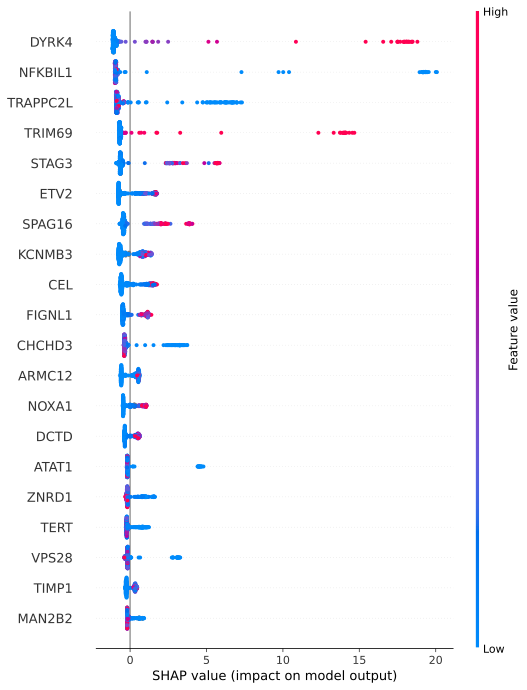

In [30]:
summary_stage_one_plot_path = locations.output.dir / "plots" / "stage_one_summary_lifespan.svg"
summary_stage_one = stage_one["lifespan"]
stage_one_figure = summary_stage_one.plot(max_display=200, plot_size=0.5, save = summary_stage_one_plot_path)
stage_one_figure

### Saving stage 1 results ###

In [31]:
for k, v in stage_one.items():
    res = v.select_repeated(2)
    res.to_csv(locations.output.stage_one / f"{k}_selected.tsv", sep="\t", index_label="reference_gene")

In [32]:
stage_one["lifespan"].select_repeated(2)

symbol  repeats  mean_shap  mean_kendall_tau  shap_0  \
ENSG00000010219     DYRK4   10.000      8.375             0.263   8.250   
ENSG00000204498   NFKBIL1   10.000      7.350            -0.141   5.500   
ENSG00000066923     STAG3   10.000      5.525             0.438   5.250   
ENSG00000185880    TRIM69   10.000      5.200             0.140   5.250   
ENSG00000105672      ETV2   10.000      3.550             0.730   2.750   
ENSG00000167515  TRAPPC2L    9.000      6.056            -0.168     nan   
ENSG00000171121    KCNMB3    9.000      4.056             0.667   5.250   
ENSG00000132436    FIGNL1    9.000      3.722             0.544   4.250   
ENSG00000157343    ARMC12    9.000      2.639             0.629   3.000   
ENSG00000170835       CEL    8.000      3.219             0.694   2.500   
ENSG00000188747     NOXA1    8.000      2.656             0.692   1.250   
ENSG00000106554    CHCHD3    7.000      2.929            -0.381     nan   
ENSG00000164362      TERT    7.000      2.893            -0.444   2.250   
ENSG00000129187      DCTD    7.000      1.607             0.624     nan   
ENSG00000144451    SPAG16    6.000      3.625             0.475     nan   
ENSG00000172531    PPP1CA    5.000      2.700            -0.712   2.000   
ENSG00000013288    MAN2B2    5.000      2.650            -0.301     nan   
ENSG00000160948     VPS28    5.000      2.250            -0.329   3.500   
ENSG00000023191      RNH1    4.000      4.000            -0.319     nan   
ENSG00000165555   NOXRED1    4.000      3.938             0.799     nan   
ENSG00000108384    RAD51C    4.000      3.438             0.388     nan   
ENSG00000142002      DPP9    4.000      2.500            -0.703   2.250   
ENSG00000152705  CATSPER3    4.000      2.062             0.684     nan   
ENSG00000132464      ENAM    4.000      2.000             0.491   2.000   
ENSG00000066926      FECH    4.000      1.875            -0.421   1.250   
ENSG00000136436  CALCOCO2    4.000      1.500             0.684     nan   
ENSG00000184983    NDUFA6    3.000      2.750            -0.638     nan   
ENSG00000165501      LRR1    3.000      2.250             0.658     nan   
ENSG00000164879       CA3    3.000      1.083            -0.435     nan   
ENSG00000182612   TSPAN10    2.000      3.875             0.453     nan   
ENSG00000137343     ATAT1    2.000      2.875            -0.403     nan   
ENSG00000142541    RPL13A    2.000      2.625            -0.185   2.750   
ENSG00000213719     CLIC1    2.000      2.500            -0.252     nan   
ENSG00000102265     TIMP1    2.000      2.000             0.589   1.500   
ENSG00000108786   HSD17B1    2.000      1.875             0.651   1.750   
ENSG00000140398     NEIL1    2.000      1.750             0.481     nan   

                 kendall_tau_0  shap_1  kendall_tau_1  shap_2  kendall_tau_2  \
ENSG00000010219          0.261   8.000          0.249   8.000          0.211   
ENSG00000204498         -0.057   8.750         -0.030   7.250         -0.114   
ENSG00000066923          0.378   4.000          0.397   8.500          0.447   
ENSG00000185880          0.073   4.500          0.313   3.750          0.119   
ENSG00000105672          0.752   3.250          0.769   2.750          0.729   
ENSG00000167515            nan   4.750         -0.205   4.750         -0.137   
ENSG00000171121          0.725   3.750          0.660     nan            nan   
ENSG00000132436          0.475   3.000          0.563     nan            nan   
ENSG00000157343          0.625   2.000          0.632     nan            nan   
ENSG00000170835          0.738   3.500          0.748     nan            nan   
ENSG00000188747          0.718   2.250          0.699   1.500          0.761   
ENSG00000106554            nan     nan            nan   4.500         -0.362   
ENSG00000164362         -0.360   2.250         -0.411     nan            nan   
ENSG00000129187            nan   1.750          0.629   1.500          0.631   
ENSG00000144451            nan   2.500     

In [33]:
result_untuned = pipelines["lifespan"].fit_transform(stage_two_selection)
result_untuned.selected

2020-09-13 01:26:36.178 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 0 =====
2020-09-13 01:26:36.179 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 9}
2020-09-13 01:26:36.183 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[187]	valid_0's l1: 7.5055	valid_0's l2: 169.317	valid_0's huber: 6.4125


2020-09-13 01:26:36.404 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[134]	valid_0's l1: 3.2507	valid_0's l2: 45.5218	valid_0's huber: 2.59336


2020-09-13 01:26:36.545 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 2.58865	valid_0's l2: 23.9482	valid_0's huber: 2.0109
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 2.58865	valid_0's l2: 23.9482	valid_0's huber: 2.0109


2020-09-13 01:26:36.750 | INFO     | yspecies.selection:fit:83 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[189]	valid_0's l1: 2.87465	valid_0's l2: 45.3888	valid_0's huber: 2.28162


2020-09-13 01:26:53.540 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.9078303485536479, MAE=4.054873715674501, MSE=71.04389475950751, huber=3.325818715622109)
2020-09-13 01:26:53.547 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 1 =====
2020-09-13 01:26:53.548 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-09-13 01:26:53.552 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[112]	valid_0's l1: 2.80204	valid_0's l2: 18.8864	valid_0's huber: 2.16997


2020-09-13 01:26:53.676 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Vombatus_ursinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[132]	valid_0's l1: 4.19379	valid_0's l2: 57.6177	valid_0's huber: 3.42983


2020-09-13 01:26:53.796 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[133]	valid_0's l1: 2.73064	valid_0's l2: 18.4232	valid_0's huber: 2.1013


2020-09-13 01:26:53.916 | INFO     | yspecies.selection:fit:83 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's l1: 5.65572	valid_0's l2: 120.532	valid_0's huber: 4.75782


2020-09-13 01:27:08.918 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.9230871847515094, MAE=3.845547939105063, MSE=53.86490586475456, huber=3.1125783675054293)
2020-09-13 01:27:08.924 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 2 =====
2020-09-13 01:27:08.924 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-09-13 01:27:08.928 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argumen

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[144]	valid_0's l1: 2.69372	valid_0's l2: 25.0217	valid_0's huber: 2.08714


2020-09-13 01:27:09.082 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Phascolarctos_cinereus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[135]	valid_0's l1: 4.58448	valid_0's l2: 73.5419	valid_0's huber: 3.78908


2020-09-13 01:27:09.209 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	valid_0's l1: 2.98955	valid_0's l2: 21.847	valid_0's huber: 2.34774


2020-09-13 01:27:09.296 | INFO     | yspecies.selection:fit:83 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[162]	valid_0's l1: 5.77812	valid_0's l2: 73.5115	valid_0's huber: 4.82512


2020-09-13 01:27:21.669 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.9218318669614944, MAE=4.011467803285494, MSE=48.480524854113426, huber=3.25294278544457)
2020-09-13 01:27:21.677 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 3 =====
2020-09-13 01:27:21.678 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-09-13 01:27:21.681 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[141]	valid_0's l1: 2.89769	valid_0's l2: 17.3819	valid_0's huber: 2.23934


2020-09-13 01:27:21.822 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ursus_americanus', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[149]	valid_0's l1: 6.912	valid_0's l2: 154.258	valid_0's huber: 5.85014


2020-09-13 01:27:21.987 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[79]	valid_0's l1: 4.09454	valid_0's l2: 51.1618	valid_0's huber: 3.32292


2020-09-13 01:27:22.076 | INFO     | yspecies.selection:fit:83 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's l1: 3.10606	valid_0's l2: 46.8325	valid_0's huber: 2.44121


2020-09-13 01:27:37.875 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.9089188597548677, MAE=4.252571702383061, MSE=67.40846883868988, huber=3.4566811721299047)
2020-09-13 01:27:37.883 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 4 =====
2020-09-13 01:27:37.884 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-09-13 01:27:37.888 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
Found `early_stopping_round` in params. Will use it instead of argument

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[220]	valid_0's l1: 3.01287	valid_0's l2: 27.7614	valid_0's huber: 2.36861


2020-09-13 01:27:38.142 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ursus_americanus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[111]	valid_0's l1: 3.64212	valid_0's l2: 49.0259	valid_0's huber: 2.95103


2020-09-13 01:27:38.252 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.55151	valid_0's l2: 28.0158	valid_0's huber: 2.86695
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 3.55151	valid_0's l2: 28.0158	valid_0's huber: 2.86695


2020-09-13 01:27:38.447 | INFO     | yspecies.selection:fit:83 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[165]	valid_0's l1: 5.71144	valid_0's l2: 100.256	valid_0's huber: 4.79808


2020-09-13 01:27:56.366 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.930191989802983, MAE=3.979483972598098, MSE=51.26478191487786, huber=3.244631437537006)
2020-09-13 01:27:56.375 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 5 =====
2020-09-13 01:27:56.376 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-09-13 01:27:56.379 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
Found `early_stopping_round` in params. Will use it instead of argument

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[75]	valid_0's l1: 2.2783	valid_0's l2: 14.3194	valid_0's huber: 1.70836


2020-09-13 01:27:56.469 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Ovis_aries', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[150]	valid_0's l1: 4.08566	valid_0's l2: 65.6919	valid_0's huber: 3.35027


2020-09-13 01:27:56.665 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[136]	valid_0's l1: 4.34632	valid_0's l2: 72.37	valid_0's huber: 3.58508


2020-09-13 01:27:56.792 | INFO     | yspecies.selection:fit:83 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[107]	valid_0's l1: 4.00717	valid_0's l2: 53.0308	valid_0's huber: 3.28733


2020-09-13 01:28:09.469 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.9293794187562116, MAE=3.6793609722896305, MSE=51.3530037353213, huber=2.9780252836211343)
2020-09-13 01:28:09.474 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 6 =====
2020-09-13 01:28:09.475 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-09-13 01:28:09.479 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it instead

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[134]	valid_0's l1: 2.48049	valid_0's l2: 18.5733	valid_0's huber: 1.91812


2020-09-13 01:28:09.644 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Suricata_suricatta']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[131]	valid_0's l1: 4.3001	valid_0's l2: 64.2049	valid_0's huber: 3.52145


2020-09-13 01:28:09.770 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	valid_0's l1: 2.76769	valid_0's l2: 21.7443	valid_0's huber: 2.14346


2020-09-13 01:28:09.848 | INFO     | yspecies.selection:fit:83 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[167]	valid_0's l1: 3.49942	valid_0's l2: 48.1784	valid_0's huber: 2.81651


2020-09-13 01:28:23.936 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.9473527807457439, MAE=3.2619233615997283, MSE=38.17521787995263, huber=2.6015780586279567)
2020-09-13 01:28:23.942 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 7 =====
2020-09-13 01:28:23.942 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-09-13 01:28:23.946 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[116]	valid_0's l1: 3.04168	valid_0's l2: 20.5751	valid_0's huber: 2.37751


2020-09-13 01:28:24.065 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_paniscus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 3.60884	valid_0's l2: 45.9663	valid_0's huber: 2.90898


2020-09-13 01:28:24.188 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[187]	valid_0's l1: 3.26443	valid_0's l2: 28.2956	valid_0's huber: 2.60535


2020-09-13 01:28:24.359 | INFO     | yspecies.selection:fit:83 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[83]	valid_0's l1: 3.81066	valid_0's l2: 44.6727	valid_0's huber: 3.10535


2020-09-13 01:28:38.111 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.9517487130156189, MAE=3.4314036958937773, MSE=34.87742535196348, huber=2.7511080663655147)
2020-09-13 01:28:38.120 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 8 =====
2020-09-13 01:28:38.121 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-09-13 01:28:38.124 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[111]	valid_0's l1: 2.90277	valid_0's l2: 20.2752	valid_0's huber: 2.26668


2020-09-13 01:28:38.248 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[127]	valid_0's l1: 3.33996	valid_0's l2: 37.943	valid_0's huber: 2.67619


2020-09-13 01:28:38.399 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[146]	valid_0's l1: 3.10432	valid_0's l2: 30.2908	valid_0's huber: 2.45671


2020-09-13 01:28:38.546 | INFO     | yspecies.selection:fit:83 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[106]	valid_0's l1: 3.30499	valid_0's l2: 52.3711	valid_0's huber: 2.63156


2020-09-13 01:28:53.845 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.9496451201810591, MAE=3.163011672679869, MSE=35.22003226390511, huber=2.5064049647685325)
2020-09-13 01:28:53.851 | INFO     | yspecies.selection:fit:79 - ===== fitting models with seed 9 =====
2020-09-13 01:28:53.852 | INFO     | yspecies.selection:fit:80 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-09-13 01:28:53.855 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
Found `early_stopping_round` in params. Will use it instead of a

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[99]	valid_0's l1: 3.27755	valid_0's l2: 27.0038	valid_0's huber: 2.60215


2020-09-13 01:28:53.967 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[114]	valid_0's l1: 5.67341	valid_0's l2: 101.044	valid_0's huber: 4.73906


2020-09-13 01:28:54.077 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 3.36084	valid_0's l2: 26.4881	valid_0's huber: 2.66332


2020-09-13 01:28:54.172 | INFO     | yspecies.selection:fit:83 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[107]	valid_0's l1: 4.3892	valid_0's l2: 61.4984	valid_0's huber: 3.60432


2020-09-13 01:29:06.955 | INFO     | yspecies.selection:transform:227 - Metrics: 
Metrics(R2=0.9294056800176123, MAE=4.175251441163073, MSE=54.00858654469263, huber=3.4046294070142604)


symbol  repeats  mean_shap  mean_kendall_tau  shap_0  \
ENSG00000204498   NFKBIL1   10.000     13.975            -0.496  17.250   
ENSG00000010219     DYRK4   10.000     13.600             0.475  12.000   
ENSG00000167515  TRAPPC2L   10.000     12.650            -0.383  12.500   
ENSG00000142002      DPP9   10.000     11.825            -0.800  14.000   
ENSG00000023191      RNH1   10.000     11.650            -0.552  16.000   
ENSG00000165501      LRR1   10.000     11.575             0.703  19.500   
ENSG00000160948     VPS28   10.000     11.225            -0.538  11.250   
ENSG00000170835       CEL   10.000     10.775             0.728   6.250   
ENSG00000137343     ATAT1   10.000      9.850            -0.578   9.000   
ENSG00000184983    NDUFA6   10.000      9.700            -0.607   8.500   
ENSG00000164362      TERT   10.000      8.800            -0.559  12.250   
ENSG00000066926      FECH   10.000      8.775            -0.538   7.250   
ENSG00000105672      ETV2   10.000      8.700             0.700  17.000   
ENSG00000132436    FIGNL1   10.000      8.700             0.550   9.500   
ENSG00000165555   NOXRED1   10.000      8.625             0.805   9.750   
ENSG00000066923     STAG3   10.000      8.600             0.484  12.250   
ENSG00000185880    TRIM69   10.000      8.500            -0.050  10.500   
ENSG00000136436  CALCOCO2   10.000      7.950             0.748   7.750   
ENSG00000013288    MAN2B2   10.000      7.625            -0.654   7.250   
ENSG00000172531    PPP1CA   10.000      7.225            -0.765   9.000   
ENSG00000164304     CAGE1   10.000      6.975            -0.728  13.750   
ENSG00000122952     ZWINT   10.000      6.950            -0.633  11.750   
ENSG00000213719     CLIC1   10.000      6.875            -0.505  11.250   
ENSG00000092529     CAPN3   10.000      6.800             0.561  11.500   
ENSG00000198663   C6orf89   10.000      6.625            -0.745   6.250   
ENSG00000142937      RPS8   10.000      6.475             0.624  11.500   
ENSG00000140398     NEIL1   10.000      6.400             0.655   8.250   
ENSG00000120992    LYPLA1   10.000      6.350            -0.590  10.750   
ENSG00000162959     MEMO1   10.000      6.275            -0.613   9.000   
ENSG00000142541    RPL13A   10.000      5.950            -0.084  10.000   
ENSG00000127952    STYXL1   10.000      5.900             0.560   8.250   
ENSG00000103150     MLYCD   10.000      5.900            -0.211  10.000   
ENSG00000106554    CHCHD3   10.000      5.825            -0.575   8.250   
ENSG00000102265     TIMP1   10.000      5.700             0.593  12.000   
ENSG00000152705  CATSPER3   10.000      5.675             0.691   6.500   
ENSG00000188747     NOXA1   10.000      5.375             0.699   4.750   
ENSG00000117151      CTBS   10.000      4.750            -0.668   5.000   
ENSG00000157343    ARMC12   10.000      4.500             0.612   8.750   
ENSG00000164879       CA3   10.000      4.075            -0.462   4.500   
ENSG00000129187      DCTD   10.000      3.550             0.658   5.250   
ENSG00000175806      MSRA    9.000      8.000            -0.299  18.000   
ENSG00000211454     AKR7L    9.000      7.639             0.009   7.500   
ENSG00000144451    SPAG16    9.000      7.583             0.494   7.500   
ENSG00000101546      RBFA    9.000      7.556             0.107  12.500   
ENSG00000138678     GPAT3    9.000      7.361             0.746   9.000   
ENSG00000053372     MRTO4    9.000      7.333            -0.704   9.250   
ENSG00000127184     COX7C    9.000      5.833             0.614   7.250   
ENSG00000120675   DNAJC15    9.000      5.694            -0.621   6.000   
ENSG00000102901     CENPT    9.000      5.611            -0.295   6.750   
ENSG00000205323     SARNP    9.000      5.417            -0.469   6.500   
ENSG00000171121    KCNMB3    9.000      5.306             0.654   5.500   
ENSG00000136942     RPL35    9.000      5.167            -0.576   8.750   
ENSG00000269058     CALR3    9.000      5.13

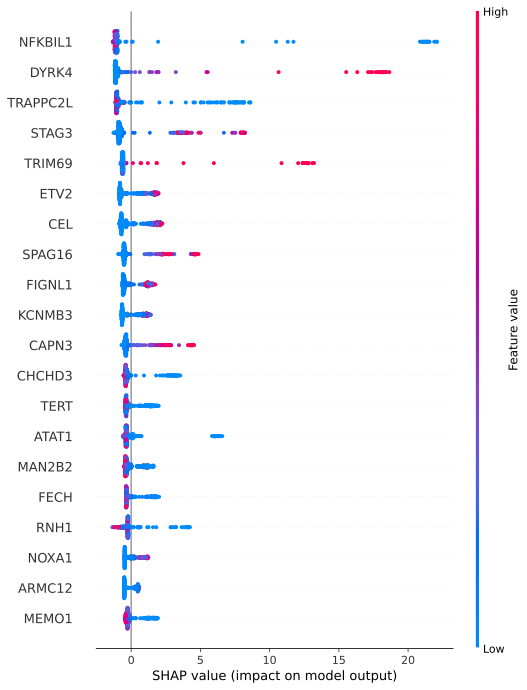

In [34]:
summary_stage_two_untuned_plot_path = locations.output.dir / "plots" / "stage_two_untuned_summary_lifespan.svg"
summary_stage_two_untuned = result_untuned.plot(max_display=200, plot_size=0.5, save = summary_stage_two_untuned_plot_path)
summary_stage_two_untuned

### Comparing metrics ###

In [ ]:
stage_one["lifespan"].metrics_average

In [ ]:
stage_one["lifespan"].symbols_repeated(6).values

In [ ]:
stage_one["lifespan"].symbols_repeated(2).index

In [ ]:
stage_one["lifespan"].validation_metrics.mean(axis=0)

In [ ]:
(stage_one["lifespan"].symbols_repeated(2).shape, result_untuned.symbols_repeated(2).shape)

In [ ]:
result_untuned.metrics_average

In [ ]:
result_untuned.validation_metrics["R^2"].mean()

In [ ]:
#result_untuned.metrics_average

In [ ]:
### Train stage 2 model with same parameters

In [ ]:
locations.output.dir / "stage_one_lifespan.csv"